In [39]:
%matplotlib inline
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy.io import fits
from astropy import units as u
import PIL
import regions
import pyavm
import numpy as np
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.figsize'] = (10,8)
pl.rcParams['figure.dpi'] = 100
pl.rcParams['font.size'] = 16

In [40]:
from astroquery.vizier import Vizier

In [41]:
basepath = '/orange/adamginsburg/jwst/brick/'

In [42]:
import sys, imp
sys.path.append(f'{basepath}/analysis/')
sys.path.append(f'{basepath}/reduction/')
import plot_tools
imp.reload(plot_tools)
from plot_tools import starzoom, make_sed

In [43]:
from plot_tools import starzoom, make_sed

In [44]:
basetable = Table.read(f'{basepath}/catalogs/crowdsource_nsky0_merged_photometry_tables_merged.fits')
len(basetable)

530916

### DEbug

#maskf405n = basetable['mag_ab_f405n'].mask.copy()
#basetable['mag_ab_f405n'].mask[:] = False
maskf405n = np.isnan(basetable['mag_ab_f405n'])
basetable['mag_ab_f405n'][maskf405n]
flux = basetable['flux_f405n']
fwhm_arcsec = 0.136*u.arcsec
pxdg = u.Quantity(basetable.meta['405pxdg'], u.deg**2)
fwhm_pix = basetable['fwhm_f405n']
flux_jy = (u.Quantity(flux, u.MJy/u.sr) * (2*np.pi / (8*np.log(2))) * fwhm_pix**2 * pxdg).to(u.Jy)

In [45]:
filternames = ['f410m', 'f212n', 'f466n', 'f405n', 'f187n', 'f182m']

In [46]:
any_saturated_ = [basetable[x] for x in basetable.colnames if 'near_sat' in x]
any_saturated = any_saturated_[0]
for row in any_saturated_[1:]:
    #print(row.sum())
    any_saturated = any_saturated | row
magerr_gtpt1 = np.logical_or.reduce([basetable[f'emag_ab_{filtername}'] > 0.2 for filtername in filternames])

In [47]:
oksep = np.logical_or.reduce([basetable[f'sep_{filtername}'] for filtername in filternames[1:]])
blue_410_466 = oksep & ~any_saturated & (~(basetable['mag_ab_410m405'].mask)) & ((basetable['mag_ab_410m405'] - basetable['mag_ab_f466n']) + (basetable['emag_ab_f410m']**2 + basetable['emag_ab_f466n']**2 + basetable['emag_ab_f405n']**2)**0.5 < -1.75)
assert (blue_410_466 & basetable['mag_ab_410m405'].mask).sum() == 0
blue_410_405 = oksep & ~any_saturated & (~(basetable['mag_ab_410m405'].mask)) & ((basetable['mag_ab_410m405'] - basetable['mag_ab_f405n']) + (basetable['emag_ab_f410m']**2 + basetable['emag_ab_f405n']**2)**0.5 < -2)
blue_405_410 = oksep & ~any_saturated & (~(basetable['mag_ab_410m405'].mask)) & ((basetable['mag_ab_405m410'] - basetable['mag_ab_410m405']) + (basetable['emag_ab_f410m']**2 + basetable['emag_ab_f405n']**2)**0.5 < -3)
blue_405_410b = oksep & ~any_saturated & (basetable['flux_f405n'] > basetable['flux_f410m']) & (~(basetable['mag_ab_f405n'].mask)) & ((basetable['mag_ab_f405n'] - basetable['mag_ab_f410m']) + (basetable['emag_ab_f410m']**2 + basetable['emag_ab_f405n']**2)**0.5 < -2) & ~magerr_gtpt1

In [48]:
blue_410_466.sum(), blue_405_410.sum(), blue_405_410b.sum()

(641, 53, 79)

In [49]:
viz = Vizier()

In [50]:
bluetbl = basetable[blue_410_466]
bluetbl.sort('flux_f410m')
bluetbl[-5:]

<Table length=5>
             skycoord_ref             sep_f410m id_f410m             skycoord_f410m                 x_f410m            y_f410m       flux_f410m passno_f410m ... flux_jy_410m405 mag_ab_410m405 flux_jy_405m410 mag_ab_405m410 flux_jy_182m187 mag_ab_182m187 flux_jy_187m182 mag_ab_187m182
               deg,deg                   deg                            deg,deg                                                                              ...        Jy                             Jy                             Jy                             Jy                     
               SkyCoord                float64   int64                  SkyCoord                    float64            float64        float32     float64    ...     float32        float32         float32        float32         float32        float32         float32        float32    
------------------------------------- --------- -------- ------------------------------------- ------------------ ------------------ ---------- ------------ ... --------------- -------------- --------------- -------------- --------------- -------------- --------------- --------------
 266.5477509847966,-28.72268815081948       0.0   105983  266.5477509847966,-28.72268815081948  2263.320039928549  1766.029123747492  7763.2197          0.0 ...     0.007137099      14.266195    0.0011480455      16.250103   1.5834888e-05      20.900963    9.985019e-06      21.401627
 266.5359641082771,-28.71699170778143       0.0    70997  266.5359641082771,-28.71699170778143  2597.857156664179   1180.41621790598  7900.4155          0.0 ...    0.0072543863      14.248499    0.0012886608      16.124653    5.713648e-05      19.507715   2.6322261e-05      20.349194
 266.54916817627117,-28.7218307868835       0.0   110203  266.54916817627117,-28.7218307868835 2311.2127340961774 1837.7935216024237   8057.517          0.0 ...     0.007440998      14.220922   0.00081962906      16.615957   3.9758255e-05      19.901432   1.2666205e-05      21.143383
266.5433836800749,-28.697395848871935       0.0    94123 266.5433836800749,-28.697395848871935  3711.789912778802 1569.3985054344553   9029.122          0.0 ...     0.008131739      14.124541    0.0030957721      15.173078    3.382704e-05       20.07684    1.259668e-05      21.149359
  266.54556276843,-28.725377648730547       0.0    99233   266.54556276843,-28.725377648730547  2111.339669979114  1654.023498244745  10210.153          0.0 ...     0.009346174      13.973415     0.001930072      15.686066   1.5108679e-05      20.951935   5.0636463e-06      22.138842

In [51]:
fov = regions.Regions.read(f'{basepath}/regions/nircam_brick_fov.reg')

In [52]:
coord = fov[0].center
height = fov[0].height
width = fov[0].width
height, width = width, height # CARTA wrote it wrong
coord, width, height

(<SkyCoord (ICRS): (ra, dec) in deg
     (266.53496367, -28.71007499)>,
 <Quantity 161.9038 arcsec>,
 <Quantity 391.024 arcsec>)

In [53]:
skycrds_cat = bluetbl['skycoord_f410m']

In [54]:
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickSpitzer_RGB_I421.png')
wwi_spitzer_unflip = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.651775 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526292809.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [55]:
spitzer = Vizier(row_limit=1e6).query_region(coordinates=coord, width=width*2, height=height*2, catalog=['II/295/SSTGC'])[0]
spitzer.add_index('SSTGC')
spitzer_crds = SkyCoord(spitzer['RAJ2000'], spitzer['DEJ2000'], frame='fk5', unit=(u.hour, u.deg))
spitzer.add_column(col=spitzer_crds, name='coordinates')
assert len(spitzer) > 1
spitzer.write('/orange/adamginsburg/spitzer/cmz_catalog_II_295_SSTGC_Ramirez2008.fits', overwrite=True)

spitzer_crds_in_field = wwi_spitzer_unflip.footprint_contains(spitzer_crds)
spitzer = spitzer[spitzer_crds_in_field]
spitzer_crds = spitzer_crds[spitzer_crds_in_field]
idx, sidx, sep, sep3d = spitzer_crds.search_around_sky(skycrds_cat, 1*u.arcsec)
len(spitzer), len(idx), len(sidx)

(1169, 21, 21)

## Plot spitzer coordinates with Ramirez 2008 overlaid

/scratch/local/64463386/ipykernel_15103/1515990771.py:1: UserWarning: You passed a edgecolor/edgecolors ('b') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  pl.scatter(spitzer_crds.ra[sidx], spitzer_crds.dec[sidx], facecolor='b', edgecolor='b', marker='x')


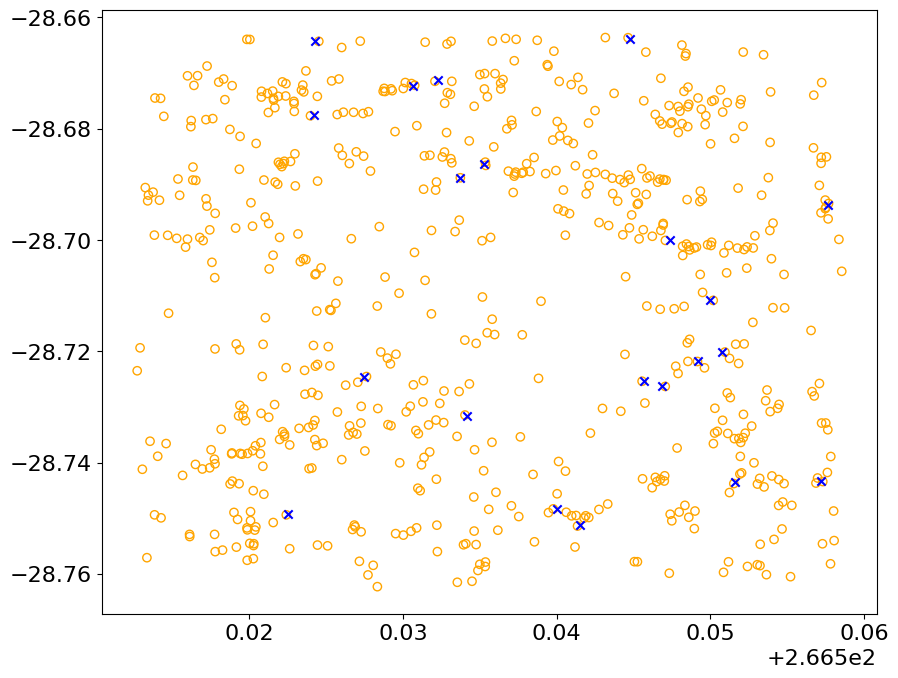

In [56]:
pl.scatter(spitzer_crds.ra[sidx], spitzer_crds.dec[sidx], facecolor='b', edgecolor='b', marker='x')
pl.scatter(skycrds_cat.ra, skycrds_cat.dec, facecolor='none', edgecolor='orange', zorder=-5)

Set OBSGEO-B to   -20.646359 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526234830.949 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


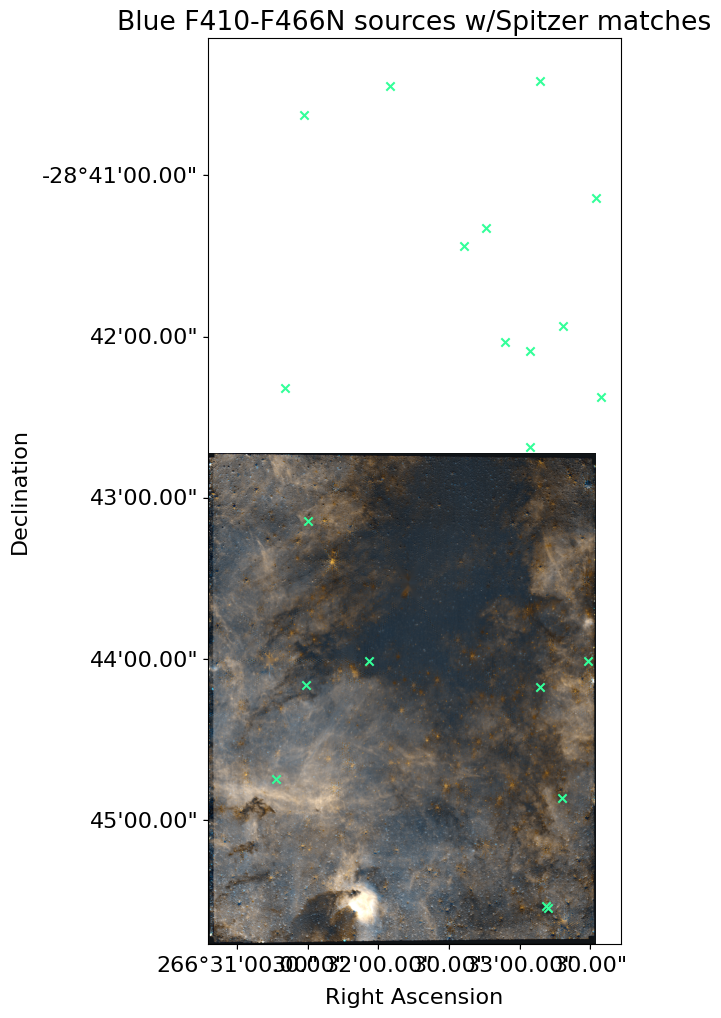

In [57]:
# This image shows only H-alpha stars
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickJWST_nrca_longwave_narrowband_rotated_lighter.png')
img_narrow = np.array(PIL.Image.open(f'{basepath}/images/BrickJWST_nrca_longwave_narrowband_rotated_lighter.png'))[::-1,:,:]
#wwi_bra_410 = avm.to_wcs(use_full_header=True)
wwi_narrow = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

img_narrow = img_narrow.swapaxes(0,1)
wwi_narrow = wwi_narrow.sub([2,1])

fig = pl.figure(figsize=(12,12))
ax = pl.subplot(projection=wwi_narrow)
ax.imshow(img_narrow)

pl.title("Blue F410-F466N sources w/Spitzer matches")

crds = basetable['skycoord_f410m']
ax.scatter(
    crds.dec[blue_410_466][idx],
    crds.ra[blue_410_466][idx],
    transform=ax.get_transform('world'),
    marker='x', facecolors=(0.2, 1, 0.6),
    #markeredgewidth=0.5,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), 
);
#ax.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))
ax.coords['ra'].set_axislabel('Right Ascension')
ax.coords['dec'].set_axislabel('Declination')

ra = lon = ax.coords['ra']
dec = lat = ax.coords['dec']
lon.set_major_formatter('dd:mm:ss.ss')
lat.set_major_formatter('dd:mm:ss.ss')
#lon.set_ticks(spacing=30. * u.arcsec, color='red')
#lat.set_ticks(spacing=30. * u.arcsec, color='blue')
#lon.set_ticklabel(color='red')
#lat.set_ticklabel(color='blue')
#lon.grid(color='red')
#lat.grid(color='blue')

dec.set_ticks_position('l')
dec.set_ticklabel_position('l')
dec.set_axislabel_position('l')
ra.set_ticks_position('b')
ra.set_ticklabel_position('b')
ra.set_axislabel_position('b')
#fig.savefig(f"{basepath}/images/BlueStarsWithSpitzerMatches_on_RGB.png", bbox_inches='tight')

Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.651775 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526292809.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


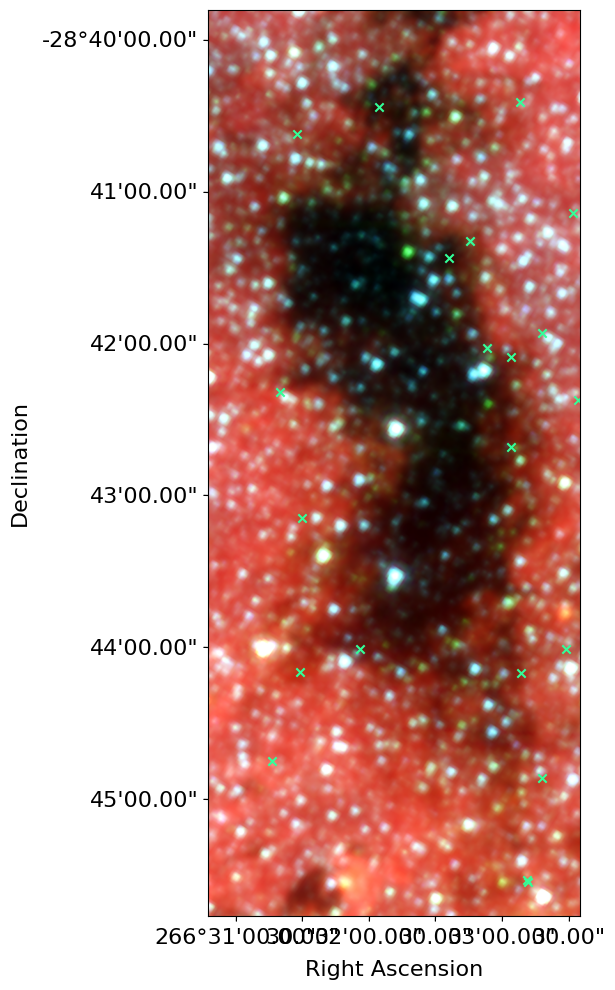

In [58]:
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickSpitzer_RGB_I421.png')
img_spitzer = np.array(PIL.Image.open(f'{basepath}/images/BrickSpitzer_RGB_I421.png'))[::-1,:,:]
wwi_spitzer_unflip = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

img_spitzer = img_spitzer.swapaxes(0,1)
wwi_spitzer = wwi_spitzer_unflip.sub([2,1])

fig = pl.figure(figsize=(12,12))
ax = pl.subplot(projection=wwi_spitzer)
ax.imshow(img_spitzer)

crds = basetable['skycoord_f410m']
ax.scatter(
    crds.dec[blue_410_466][idx],
    crds.ra[blue_410_466][idx],
    transform=ax.get_transform('world'),
    marker='x', facecolors=(0.2, 1, 0.6),
    #markeredgewidth=0.5,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), 
);
#ax.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))
ax.coords['ra'].set_axislabel('Right Ascension')
ax.coords['dec'].set_axislabel('Declination')

ra = lon = ax.coords['ra']
dec = lat = ax.coords['dec']
lon.set_major_formatter('dd:mm:ss.ss')
lat.set_major_formatter('dd:mm:ss.ss')
#lon.set_ticks(spacing=30. * u.arcsec, color='red')
#lat.set_ticks(spacing=30. * u.arcsec, color='blue')
#lon.set_ticklabel(color='red')
#lat.set_ticklabel(color='blue')
#lon.grid(color='red')
#lat.grid(color='blue')

dec.set_ticks_position('l')
dec.set_ticklabel_position('l')
dec.set_axislabel_position('l')
ra.set_ticks_position('b')
ra.set_ticklabel_position('b')
ra.set_axislabel_position('b')
#fig.savefig(f"{basepath}/images/BlueStarsWithSpitzerMatches_on_RGB.png", bbox_inches='tight')

In [59]:
spitzer[:3]

<Table length=3>
 SSTGC    RAJ2000     DEJ2000     Jmag    Hmag    Ksmag   _3.6mag _4.5mag _5.8mag _8.0mag IRAC _2M               coordinates             
                                  mag     mag      mag      mag     mag     mag     mag                            deg,deg               
  str7     str11       str11    float32 float32  float32  float32 float32 float32 float32 str4 str2                SkyCoord              
------- ----------- ----------- ------- -------- -------- ------- ------- ------- ------- ---- ---- -------------------------------------
0587868 17 46 02.85 -28 40 12.2  16.356   12.092   10.268   8.880   8.877   8.521   8.613 IRAC   2M        266.511875,-28.670055555555557
0587987 17 46 02.88 -28 40 56.9      --       --       --  11.862  11.750  11.650      -- IRAC   2M           266.512,-28.682472222222223
0588048 17 46 02.91 -28 41 10.7  16.354   13.242   11.082   9.990   9.987   9.204   8.947 IRAC   2M 266.5121249999999,-28.686305555555556

Text(0, 0.5, 'I2-I4')

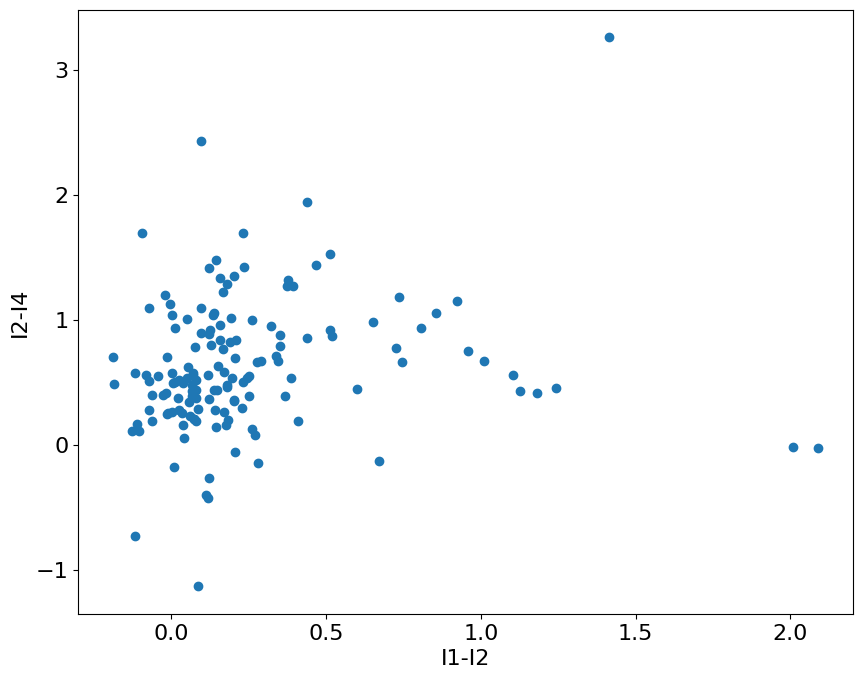

In [60]:
pl.scatter(spitzer['_3.6mag'] - spitzer['_4.5mag'],  spitzer['_4.5mag'] - spitzer['_8.0mag'])
pl.xlabel("I1-I2")
pl.ylabel("I2-I4")

Text(0, 0.5, 'I2')

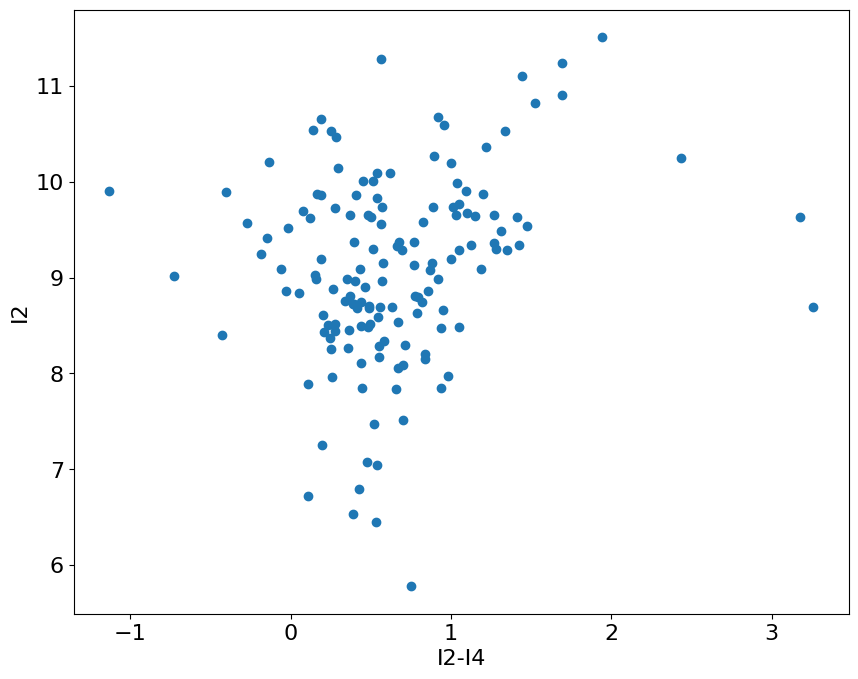

In [61]:
pl.scatter(spitzer['_4.5mag'] - spitzer['_8.0mag'],  spitzer['_4.5mag'])
pl.xlabel("I2-I4")
pl.ylabel("I2")

Text(0, 0.5, 'I2-I4')

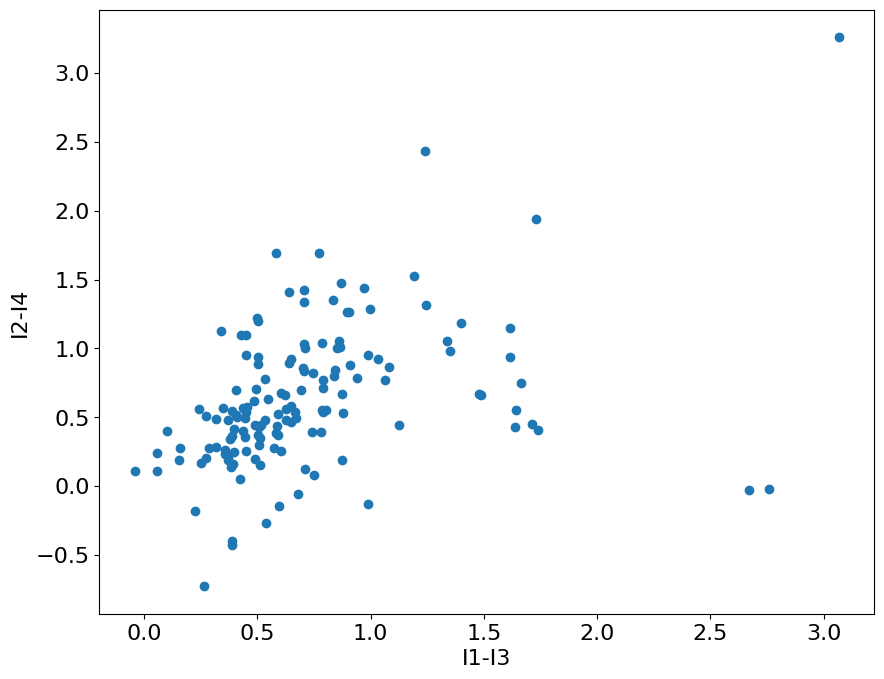

In [62]:
pl.scatter(spitzer['_3.6mag'] - spitzer['_5.8mag'],  spitzer['_4.5mag'] - spitzer['_8.0mag'])
pl.xlabel("I1-I3")
pl.ylabel("I2-I4")

In [63]:
wwi_spitzer.world_to_pixel(spitzer_crds[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0])

(array([  6.94763763,  26.45448607,  20.32406318,  40.98150225,
        196.08575698, 277.73480409, 315.53324653, 398.56227854,
        446.52683274, 463.78622616, 515.68907643]),
 array([ 662.57186034,  778.95768184,  199.61880154, 1326.42026218,
         156.87255305,  137.76951954, 1040.47277236,  767.74140476,
         287.58311956,   52.36904822, 1117.56988696]))

Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.651775 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526292809.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


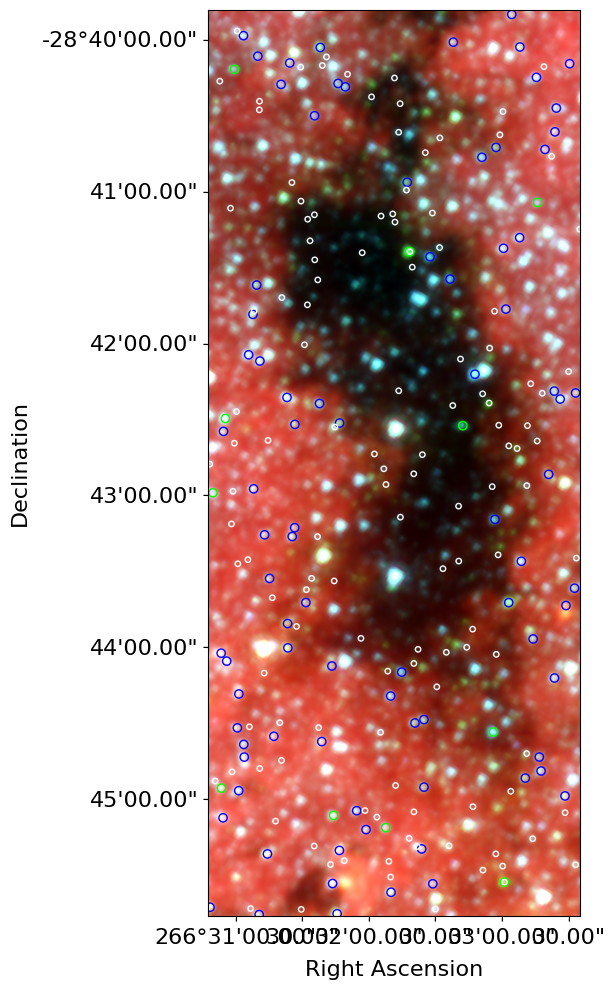

In [64]:
# This image shows only H-alpha stars
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickSpitzer_RGB_I421.png')
img_spitzer = np.array(PIL.Image.open(f'{basepath}/images/BrickSpitzer_RGB_I421.png'))[::-1,:,:]
#wwi_bra_410 = avm.to_wcs(use_full_header=True)
wwi_spitzer_unflip = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

img_spitzer = img_spitzer.swapaxes(0,1)
wwi_spitzer = wwi_spitzer_unflip.sub([2,1])

fig = pl.figure(figsize=(12,12))
ax = pl.subplot(projection=wwi_spitzer)
ax.imshow(img_spitzer)
axlims = ax.axis()

green_spitzer = (spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0.)
green_nored = ((spitzer['_4.5mag'] < 10) & (spitzer['_8.0mag'].mask))
xx,yy = wwi_spitzer.world_to_pixel(spitzer_crds[green_spitzer])
ax.scatter(
    xx,yy,
    #spitzer_crds.ra[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #spitzer_crds.dec[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #transform=ax.get_transform('fk5'),
    marker='o', edgecolors='lime', facecolors='none',
    #markeredgewidth=0.5,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), a 
);
xx,yy = wwi_spitzer.world_to_pixel(spitzer_crds[green_nored])
ax.scatter(
    xx,yy,
    marker='o', edgecolors='b', facecolors='none',
);
redi1i2_spitzer = (spitzer['_3.6mag'] - spitzer['_4.5mag'] > 1.75)# | ((10 < spitzer['_4.5mag']) & (spitzer['_4.5mag'] < 15) & (spitzer['_8.0mag'].mask))
xx,yy = wwi_spitzer.world_to_pixel(spitzer_crds[redi1i2_spitzer])
ax.scatter(
    xx,yy,
    #spitzer_crds.ra[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #spitzer_crds.dec[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #transform=ax.get_transform('fk5'),
    marker='o', edgecolors='w', facecolors='none',
s=15,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), a 
);
#ax.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))
ax.coords['ra'].set_axislabel('Right Ascension')
ax.coords['dec'].set_axislabel('Declination')

ra = lon = ax.coords['ra']
dec = lat = ax.coords['dec']
lon.set_major_formatter('dd:mm:ss.ss')
lat.set_major_formatter('dd:mm:ss.ss')
#lon.set_ticks(spacing=30. * u.arcsec, color='red')
#lat.set_ticks(spacing=30. * u.arcsec, color='blue')
#lon.set_ticklabel(color='red')
#lat.set_ticklabel(color='blue')
#lon.grid(color='red')
#lat.grid(color='blue')

ax.axis(axlims)

dec.set_ticks_position('l')
dec.set_ticklabel_position('l')
dec.set_axislabel_position('l')
ra.set_ticks_position('b')
ra.set_ticklabel_position('b')
ra.set_axislabel_position('b')
#fig.savefig(f"{basepath}/images/BlueStarsWithSpitzerMatches_on_RGB.png", bbox_inches='tight')

In [65]:
coord = SkyCoord('17:46:08.914 -28:41:22.51', frame='fk5', unit=(u.hour, u.deg))
radius = 0.5*u.arcsec

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (266.53714167, -28.68958611)>

<Figure size 1200x400 with 0 Axes>

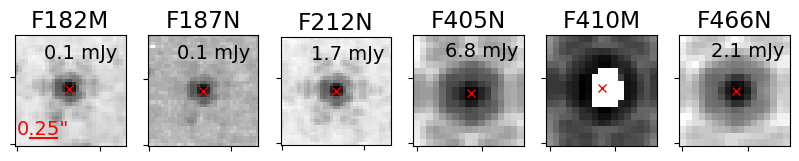

<Figure size 1200x400 with 0 Axes>

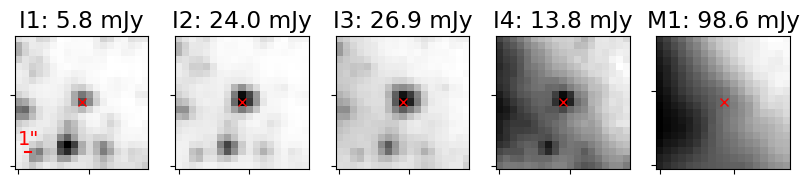

In [66]:
import sys, imp
sys.path.append(f'{basepath}/analysis/')
sys.path.append(f'{basepath}/reduction/')
import plot_tools
imp.reload(plot_tools)
from plot_tools import starzoom, make_sed, starzoom_spitzer
starzoom(coord)
starzoom_spitzer(coord)
coord

In [67]:
(coord.separation(skycrds_cat) < radius).sum()

0

In [68]:
coord = SkyCoord('17:46:08.914 -28:41:22.51', frame='fk5', unit=(u.hour, u.deg))
radius = 0.5*u.arcsec

skycrds_cat = basetable['skycoord_f410m']
idx = coord.separation(skycrds_cat) < radius
if len(idx) == 0:
    raise

spitzer_ = Vizier.query_region(coordinates=coord, radius=radius, catalog=['II/295/SSTGC'])[0]
if len(spitzer) > 0:
    spitzer_crds_ = SkyCoord(spitzer_['RAJ2000'], spitzer_['DEJ2000'], frame='fk5', unit=(u.hour, u.deg))
    spitzindex = coord.separation(spitzer_crds_) < radius
    print(len(spitzindex))
    spitzermatch = spitzer_[spitzindex]

vvvdr2 = Vizier.query_region(coordinates=coord, radius=0.5*u.arcsec, catalog=['II/348/vvv2'])[0]
if len(spitzer) > 0:
    vvvdr2_crds = SkyCoord(vvvdr2['RAJ2000'], vvvdr2['DEJ2000'], frame='fk5', unit=(u.hour, u.deg))
    vvvindex = coord.separation(vvvdr2_crds) < radius
    print(len(vvvindex))
    vvvmatch = vvvdr2[vvvindex]

1
1


In [69]:
from astroquery.svo_fps import SvoFps

In [70]:
for filtername in filternames:
    telescope = 'JWST'
    instrument = 'NIRCAM'
    wavelength_table = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filtername}')

In [71]:
spitzer[:1]

<Table length=1>
 SSTGC    RAJ2000     DEJ2000     Jmag    Hmag    Ksmag   _3.6mag _4.5mag _5.8mag _8.0mag IRAC _2M           coordinates          
                                  mag     mag      mag      mag     mag     mag     mag                        deg,deg            
  str7     str11       str11    float32 float32  float32  float32 float32 float32 float32 str4 str2            SkyCoord           
------- ----------- ----------- ------- -------- -------- ------- ------- ------- ------- ---- ---- ------------------------------
0587868 17 46 02.85 -28 40 12.2  16.356   12.092   10.268   8.880   8.877   8.521   8.613 IRAC   2M 266.511875,-28.670055555555557

In [72]:
    skycrds_cat = basetable['skycoord_f410m']
    idx = coord.separation(skycrds_cat) < radius
    if len(idx) == 0:
        raise
    else:
        idx = np.argmin(coord.separation(skycrds_cat))

    spitzer_this = Vizier.query_region(coordinates=coord, radius=radius, catalog=['II/295/SSTGC'])[0]
    if len(spitzer) > 0:
        spitzer_crds_ = SkyCoord(spitzer_this['RAJ2000'], spitzer_this['DEJ2000'], frame='fk5', unit=(u.hour, u.deg))
        spitzindex = coord.separation(spitzer_crds_) < radius
        print(len(spitzindex))
        spitzermatch = spitzer_this[spitzindex]

    vvvdr2 = Vizier.query_region(coordinates=coord, radius=0.5*u.arcsec, catalog=['II/348/vvv2'])[0]
    if len(spitzer) > 0:
        vvvdr2_crds = SkyCoord(vvvdr2['RAJ2000'], vvvdr2['DEJ2000'], frame='fk5', unit=(u.hour, u.deg))
        vvvindex = coord.separation(vvvdr2_crds) < radius
        print(len(vvvindex))
        vvvmatch = vvvdr2[vvvindex]

    wavelengths = []
    fluxes = []
    widths = []
    telescope = 'JWST'
    instrument = 'NIRCAM'
    filter_table = SvoFps.get_filter_list(facility=telescope, instrument=instrument)
    filter_table.add_index('filterID')
    for filtername in filternames:
        instrument = 'NIRCam'
        filtername = filtername.upper()
        eff_wavelength = filter_table.loc[f'{telescope}/{instrument}.{filtername}']['WavelengthEff'] * u.AA
        wavelengths.append(eff_wavelength)
        eff_width = filter_table.loc[f'{telescope}/{instrument}.{filtername}']['WidthEff'] * u.AA
        widths.append(eff_width)
        filtername = filtername.lower()
        fluxes.append(basetable[f'flux_jy_{filtername}'][idx] * u.Jy)


    telescope = 'Spitzer'
    instrument = 'IRAC'
    filter_table = SvoFps.get_filter_list(facility=telescope, instrument=instrument)
    filter_table.add_index('filterID')
    for filtername,colname in [('I1', '_3.6mag'),
                               ('I2', '_4.5mag'),
                               ('I3', '_5.8mag'),
                               ('I4', '_8.0mag')]:
        eff_wavelength = filter_table.loc[f'{telescope}/{instrument}.{filtername}']['WavelengthEff'] * u.AA
        wavelengths.append(eff_wavelength)
        fluxes.append(10**(-spitzermatch[colname][0]/2.5) * filter_table.loc[f'{telescope}/{instrument}.{filtername}']['ZeroPoint'] * u.Jy)
        eff_width = filter_table.loc[f'{telescope}/{instrument}.{filtername}']['WidthEff'] * u.AA
        widths.append(eff_width)


1
1


In [73]:
filternames

['f410m', 'f212n', 'f466n', 'f405n', 'f187n', 'f182m']

In [74]:
fluxes, widths

([<Quantity 0. Jy>,
  <Quantity 1.3366431e-05 Jy>,
  <Quantity 0.04736535 Jy>,
  <Quantity 0. Jy>,
  <Quantity 0. Jy>,
  <Quantity 0. Jy>,
  <Quantity 0.01141275 Jy>,
  <Quantity 0.05058216 Jy>,
  <Quantity 0.05510747 Jy>,
  <Quantity 0.01762664 Jy>],
 [<Quantity 4262.85790239 Angstrom>,
  <Quantity 274.27440341 Angstrom>,
  <Quantity 535.40523943 Angstrom>,
  <Quantity 454.87184789 Angstrom>,
  <Quantity 236.68645057 Angstrom>,
  <Quantity 2250.8124937 Angstrom>,
  <Quantity 6836.18018646 Angstrom>,
  <Quantity 8649.92060205 Angstrom>,
  <Quantity 12561.17490202 Angstrom>,
  <Quantity 25288.49843082 Angstrom>])

<ErrorbarContainer object of 3 artists>

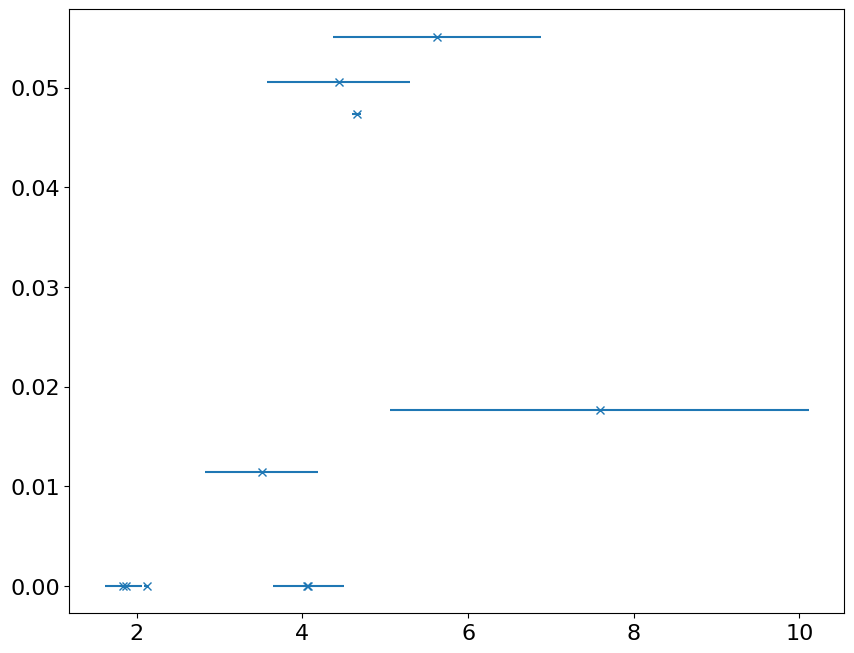

In [75]:
pl.errorbar(u.Quantity(wavelengths, u.um),
            u.Quantity([u.Quantity(x, u.Jy) for x in fluxes], u.Jy),
            xerr=widths, linestyle='none', marker='x')

# TODO: figure out where the green spitzer sources are

and what they are


Are they 4.5 micron excess?

5-8 micron dropout?

what?

In [76]:
bright_green_star_list = ['0604691', '0608824', '0611502', '0613733', '0611429', '0612623', '0613626', '0612695']

In [77]:
spitzer.add_index('SSTGC')

In [78]:
selind = spitzer.loc[bright_green_star_list[0]]
selind

<Row index=639>
 SSTGC    RAJ2000     DEJ2000     Jmag    Hmag    Ksmag   _3.6mag _4.5mag _5.8mag _8.0mag IRAC _2M               coordinates              
                                  mag     mag      mag      mag     mag     mag     mag                            deg,deg                
  str7     str11       str11    float32 float32  float32  float32 float32 float32 float32 str4 str2                SkyCoord               
------- ----------- ----------- ------- -------- -------- ------- ------- ------- ------- ---- ---- --------------------------------------
0604691 17 46 08.93 -28 41 22.5  15.819   14.663   12.374  10.953   8.864   8.285   8.895 IRAC   2M 266.53720833333324,-28.689583333333335

In [79]:
from astropy.coordinates import SkyCoord

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/quantity.py:550: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(


Text(0.5, 1.0, '0604691')

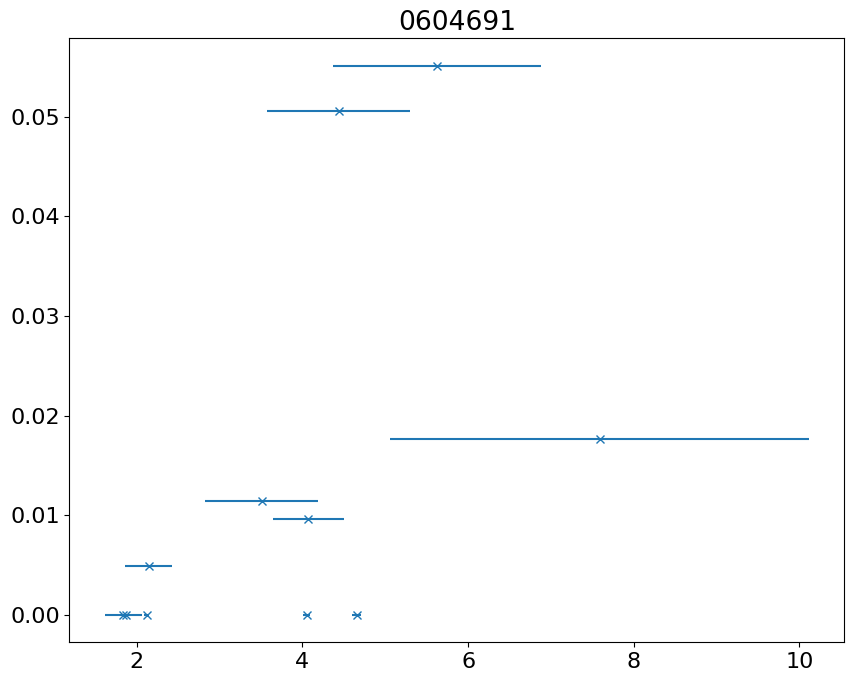

In [80]:
starid = bright_green_star_list[0]
selstar = spitzer.loc[starid]
coord = SkyCoord(selstar['RAJ2000'], selstar['DEJ2000'], frame='fk5', unit=(u.h, u.deg))
wavelengths, widths, fluxes, lims = make_sed(coord, basetable=basetable, radius=1*u.arcsec)
pl.errorbar(u.Quantity(wavelengths, u.um), u.Quantity([u.Quantity(x, u.Jy) for x in fluxes], u.Jy), xerr=widths, linestyle='none', marker='x')
pl.title(starid)

In [81]:
vvvdr2[:2]

<Table length=1>
 RAJ2000    DEJ2000           iauname          mClass  Zmag3  e_Zmag3 Zperrbits  Ymag3  e_Ymag3 Yperrbits  Jmag3  e_Jmag3 Jperrbits  Hmag3  e_Hmag3 Hperrbits  Ksmag3 e_Ksmag3 Ksperrbits
   deg        deg                                       mag     mag               mag     mag               mag     mag               mag     mag               mag     mag              
 float64    float64            str24           int16  float32 float64   int32   float64 float64   int32   float64 float64   int32   float64 float64   int32   float64 float64    int32   
---------- ---------- ------------------------ ------ ------- ------- --------- ------- ------- --------- ------- ------- --------- ------- ------- --------- ------- -------- ----------
266.537139 -28.689561 VVV J174608.91-284122.41     -1      --      --         0      --      --         0      --      --         0      --      --         0  12.816    0.013          0

In [82]:
def starzoom_(x):
    starzoom(x)
    starzoom_spitzer(x)

In [83]:
len(spitzer_crds)

1169

In [84]:
assert len(spitzer_crds) > 0

In [85]:
greenstarregs = regions.Regions.read('../regions/green_spitzer_stars.reg')
greenstarregcenters = SkyCoord([gs.center for gs in greenstarregs])
inds_green, rev_inds, sep, sep3d = greenstarregcenters.search_around_sky(spitzer_crds, 2*u.arcsec)
inds_green_jw, sep_green_jw, sep_green_jw_3d = greenstarregcenters.match_to_catalog_sky(crds)
len(inds_green), len(greenstarregcenters), len(inds_green_jw), sep_green_jw.max().to(u.arcsec)

(24, 27, 27, <Angle 0.19849629 arcsec>)

In [86]:
greenstarregcenters[:2]

<SkyCoord (Galactic): (l, b) in deg
    [(0.2708176, 0.0294995), (0.2678877, 0.0213613)]>

In [87]:
basetable[inds_green_jw][:2]['mag_ab_f410m', 'flux_f410m', 'replaced_saturated_f410m', 'mag_ab_f405n', 'flux_f405n', 'replaced_saturated_f405n'].mask

<Table length=2>
mag_ab_f410m flux_f410m replaced_saturated_f410m mag_ab_f405n flux_f405n replaced_saturated_f405n
    bool        bool              bool               bool        bool              bool          
------------ ---------- ------------------------ ------------ ---------- ------------------------
        True       True                    False        False      False                    False
       False      False                    False        False      False                    False

In [88]:
basetable[inds_green_jw][:2]['mag_ab_f410m', 'flux_f410m', 'replaced_saturated_f410m', 'mag_ab_f405n', 'dflux_f405n', 'flux_f405n', 'replaced_saturated_f405n']

<Table length=2>
mag_ab_f410m flux_f410m replaced_saturated_f410m mag_ab_f405n dflux_f405n flux_f405n replaced_saturated_f405n
  float32     float32             bool             float32      float32    float32             bool          
------------ ---------- ------------------------ ------------ ----------- ---------- ------------------------
          --         --                     True     16.74596    8.316901  706.03046                    False
   10.981751  294065.53                     True    11.407397   1669.2806  201627.14                     True

In [89]:
import warnings

In [90]:
import sys, imp
sys.path.append(f'{basepath}/analysis/')
sys.path.append(f'{basepath}/reduction/')
import plot_tools
imp.reload(plot_tools)
from plot_tools import starzoom, make_sed, starzoom_spitzer

In [91]:
len(spitzer), len(inds_green)

(1169, 24)

In [92]:
def triplot(ii):
    fig = pl.figure(figsize=(12, 12))
    ax = pl.subplot(2,1,1)
    try:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            selstar_ = spitzer[inds_green][ii]
            starid = selstar_['SSTGC']
            #coord = SkyCoord(selstar['RAJ2000'], selstar['DEJ2000'], frame='fk5', unit=(u.h, u.deg))
            coord = greenstarregcenters[ii]
            wavelengths, widths, fluxes, lims = map(u.Quantity, make_sed(coord, basetable=basetable, radius=1*u.arcsec))
            lamflam = (fluxes * wavelengths.to(u.Hz, u.spectral())).to(u.erg/u.s/u.cm**2)
            lamflamlim = (lims * wavelengths.to(u.Hz, u.spectral())).to(u.erg/u.s/u.cm**2)
            pl.errorbar(u.Quantity(wavelengths, u.um), 
                        lamflam, #u.Quantity([u.Quantity(x, u.Jy) for x in fluxes], u.Jy),
                        xerr=[w/2 for w in widths], linestyle='none', marker='x')
            pl.errorbar(wavelengths.to(u.um), lamflamlim, xerr=[w/2 for w in widths], linestyle='none', marker='v')
            pl.title(f"SSTGC {starid}")
            pl.ylabel(r"$\lambda F_\lambda$ [erg s$^{-1}$ cm$^{-2}$]")
            pl.xlabel(r"Wavelength [$\mu$m]")
            pl.semilogy()
            axes = [pl.subplot(4, 6, ii) for ii in range(13, 20)]
            starzoom(coord, fig=fig, axes=axes)
            axes = [pl.subplot(4, 5, ii) for ii in range(16, 21)]
            starzoom_spitzer(coord, fig=fig, axes=axes)
            #return list(zip(wavelengths, widths))
    except Exception as ex:
        print(ex)

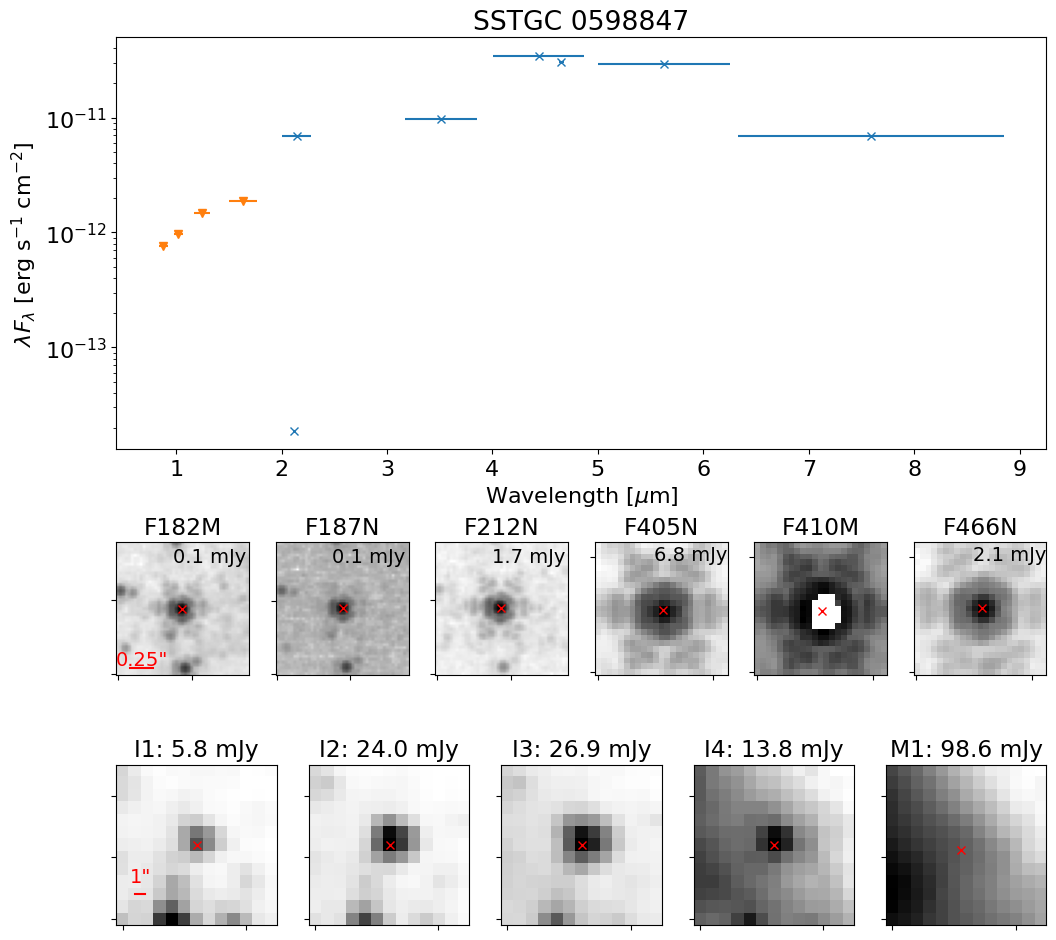

In [93]:
triplot(0)

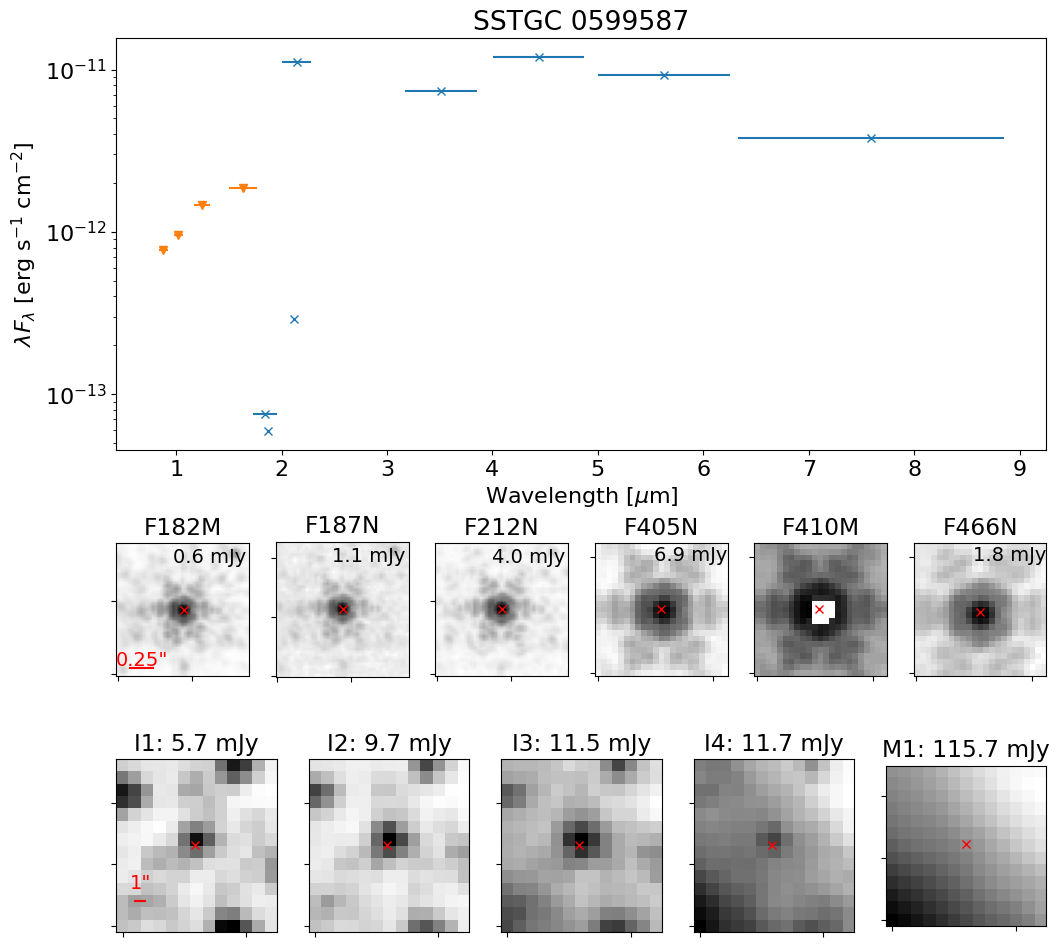

In [94]:
triplot(1)

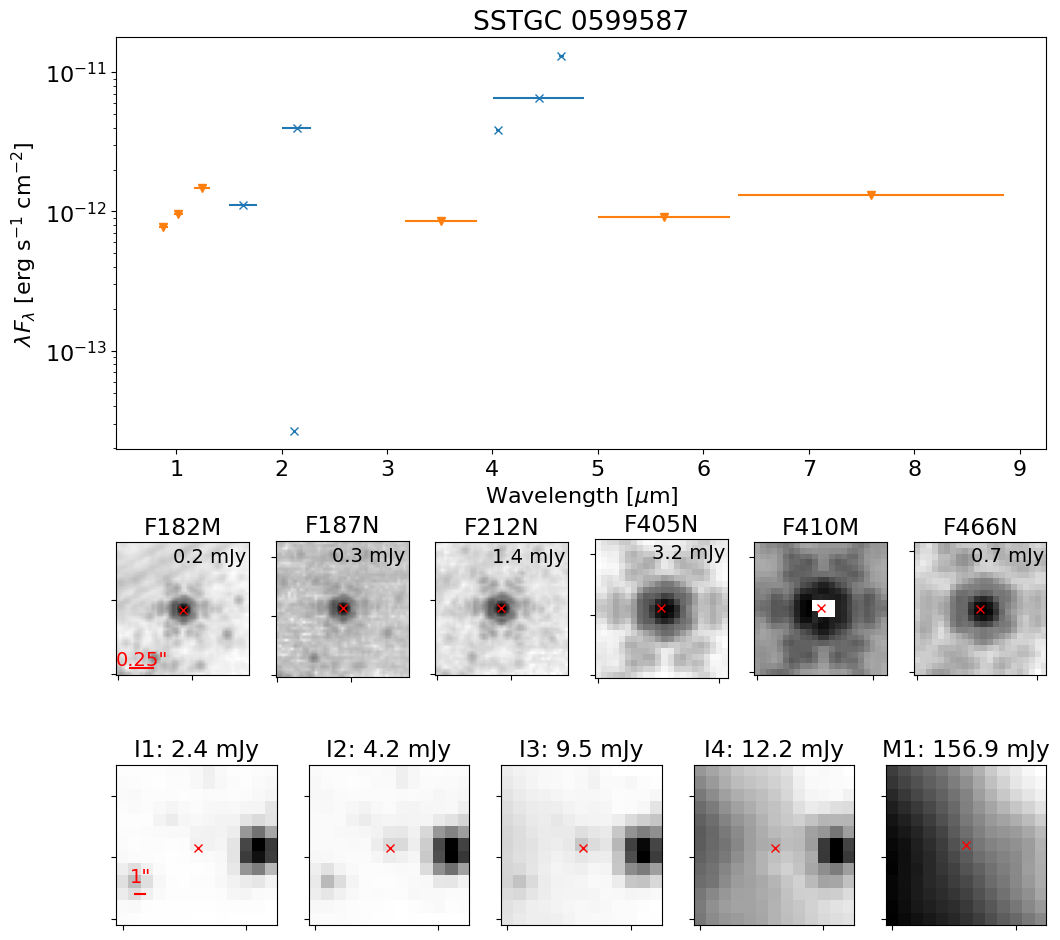

In [95]:
triplot(2)

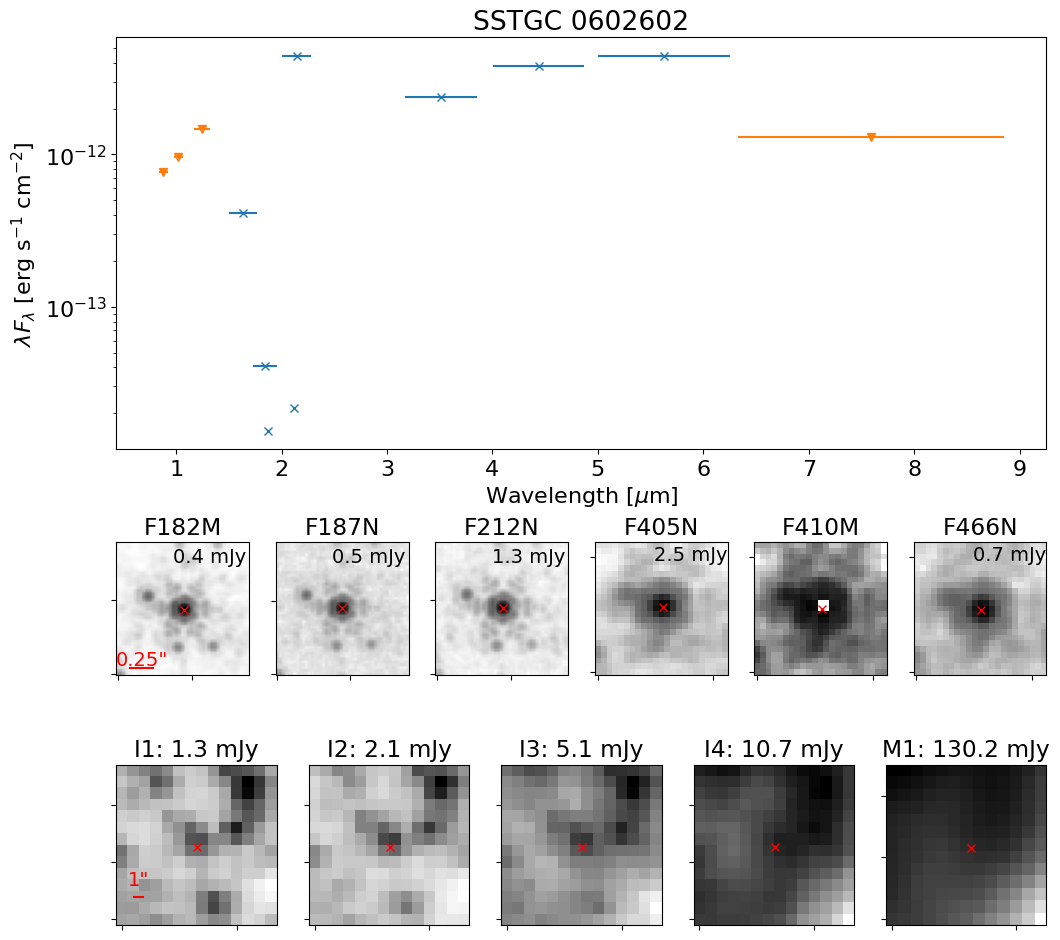

In [96]:
triplot(3)

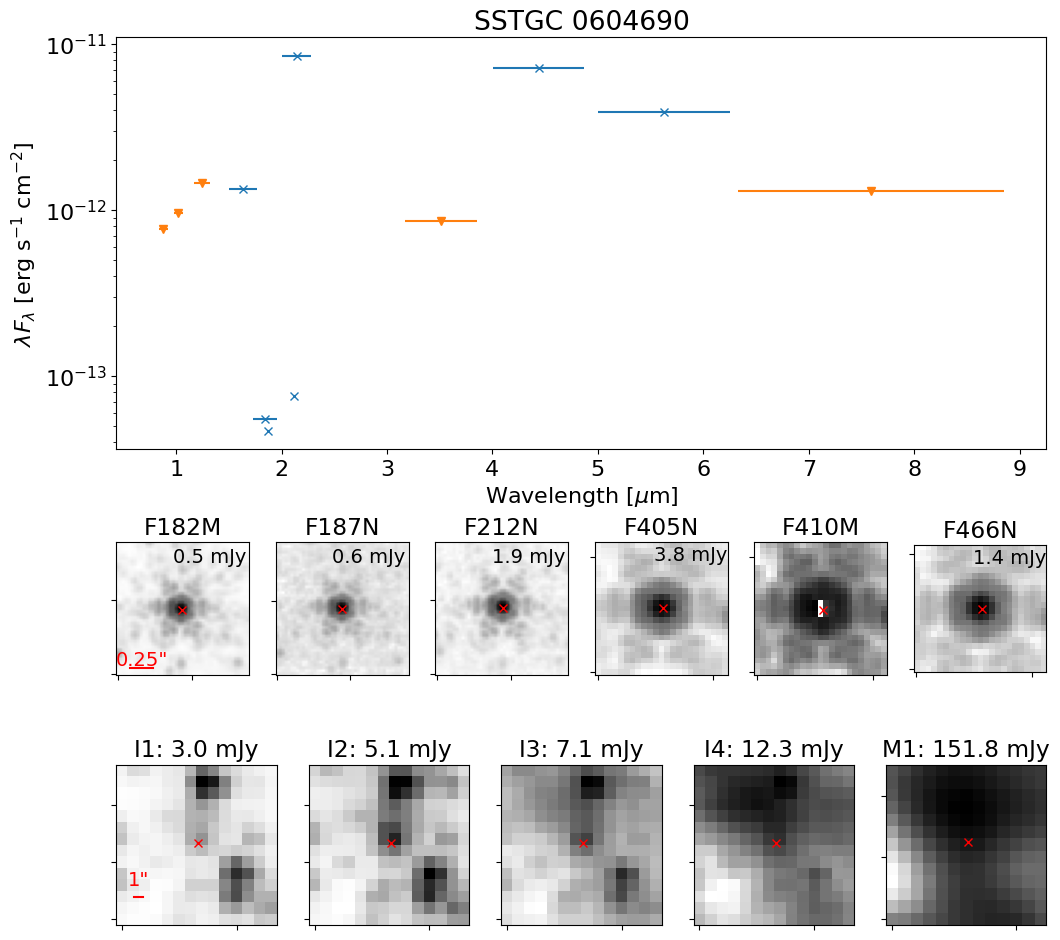

In [97]:
triplot(4)

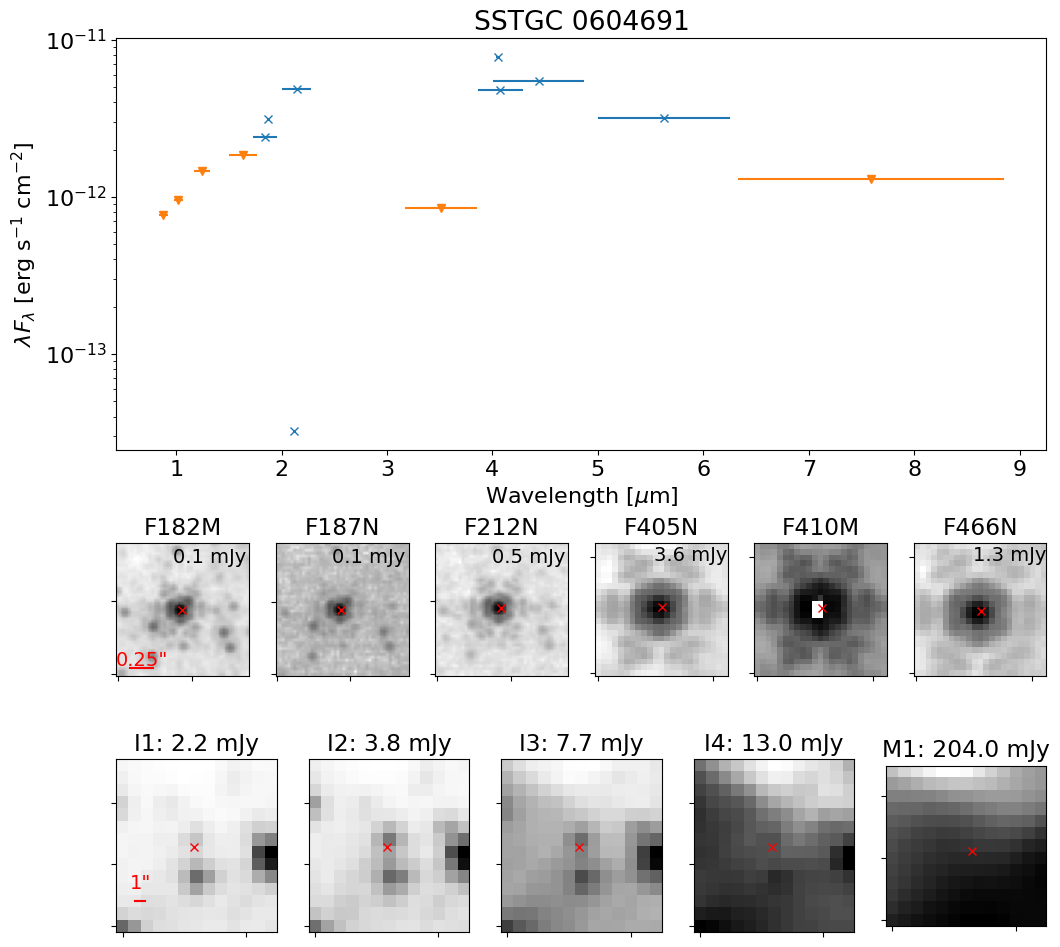

In [98]:
triplot(5)

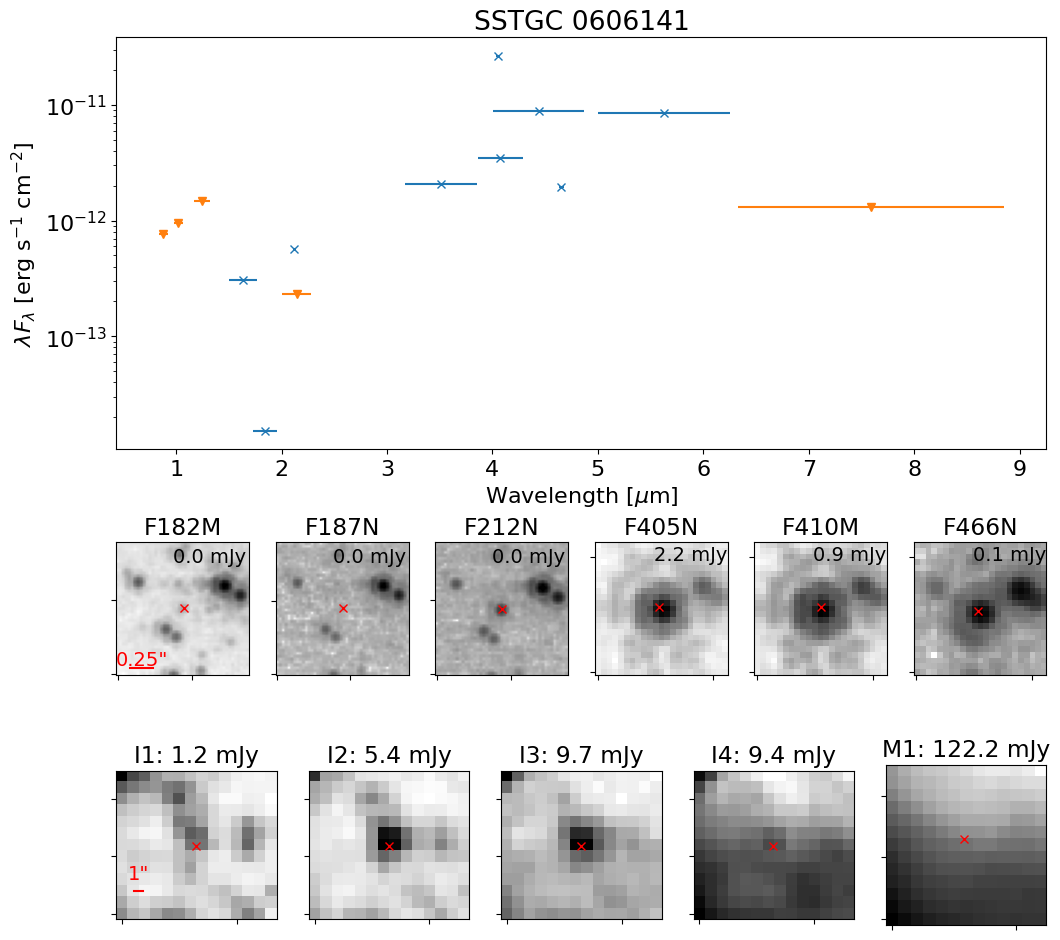

In [99]:
triplot(6)

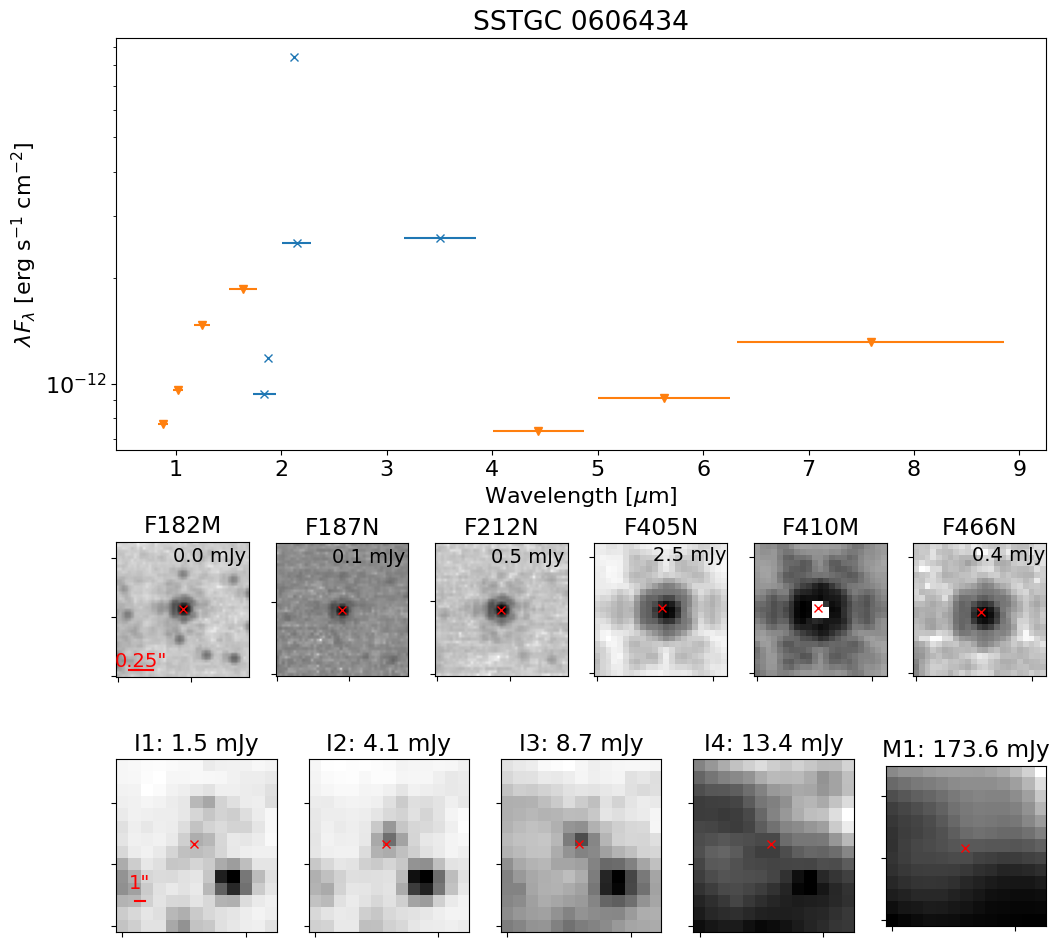

In [100]:
triplot(7)

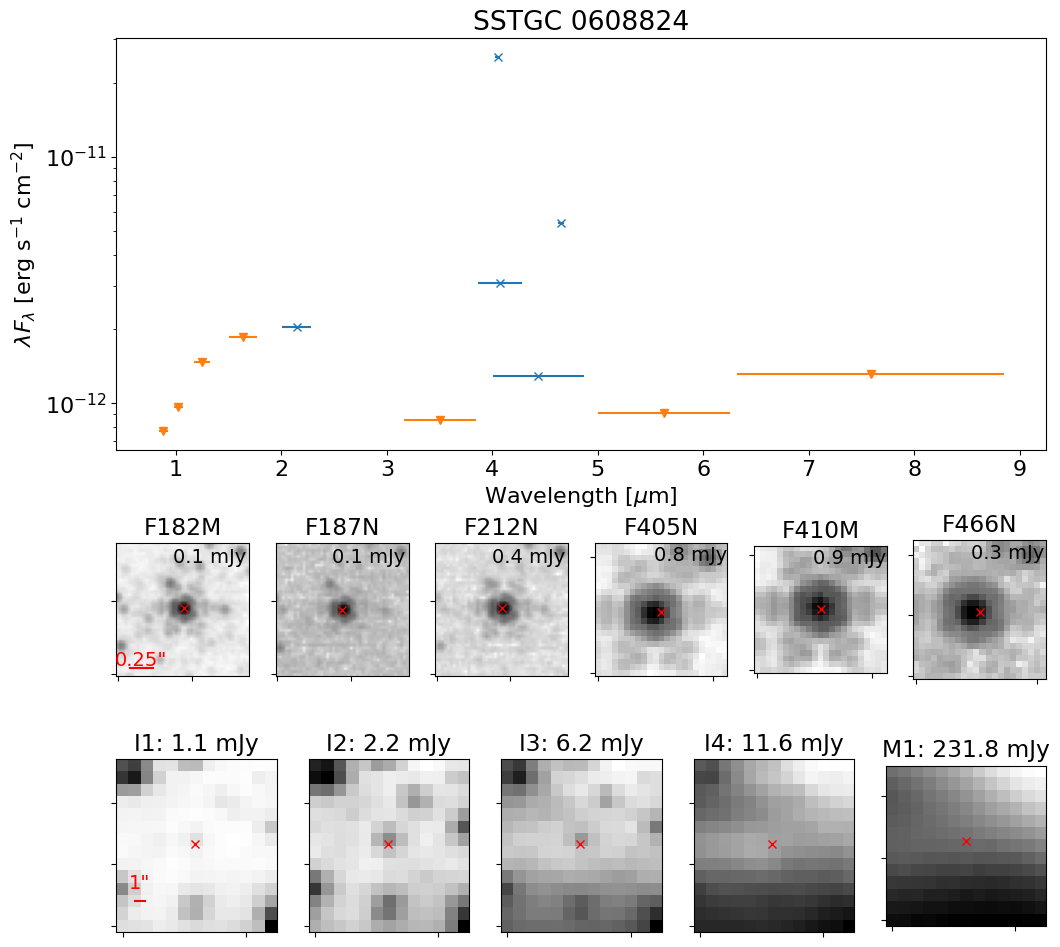

In [101]:
triplot(8)

INFO: No VVV match [plot_tools]


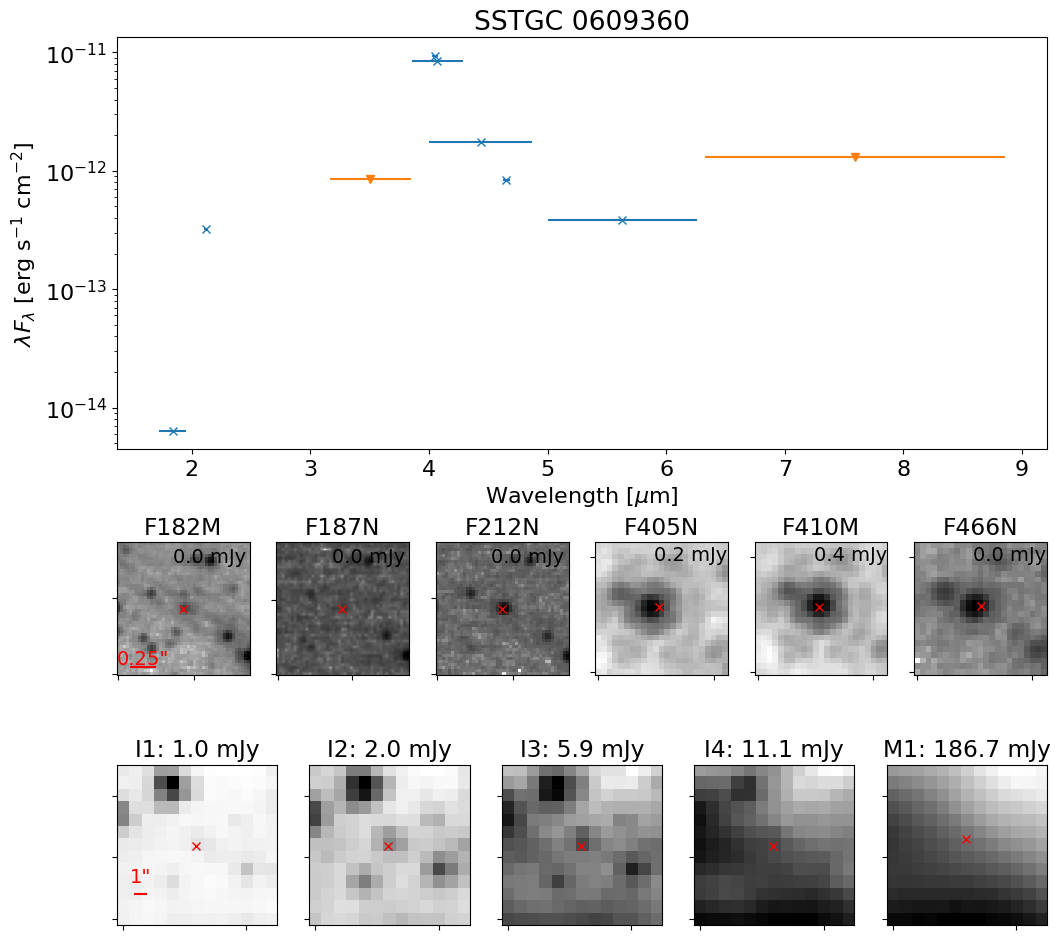

In [102]:
triplot(9)

INFO: No VVV match [plot_tools]


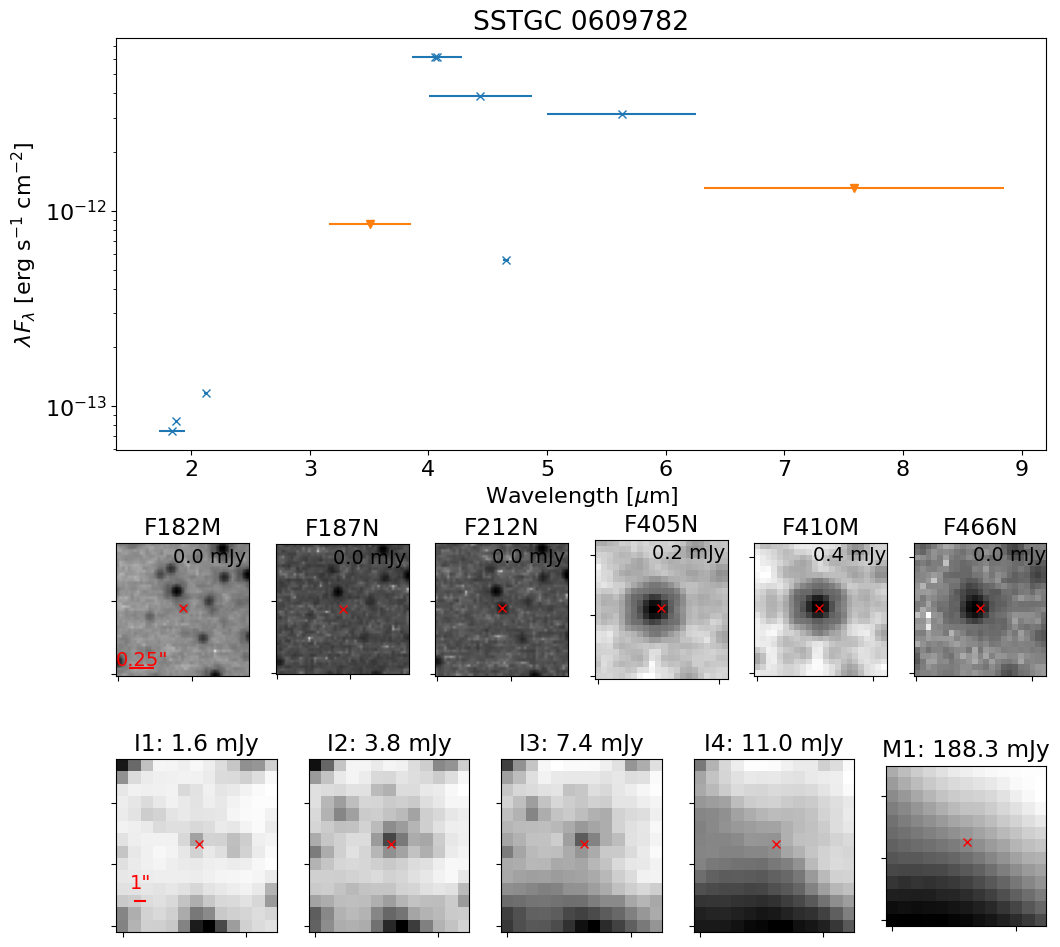

In [103]:
triplot(10)

The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


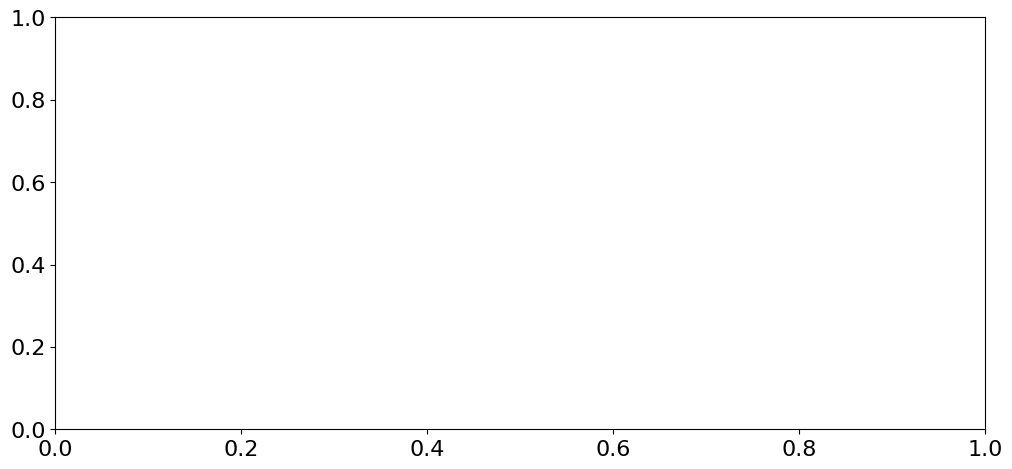

In [104]:
triplot(11)

INFO: No matches for spitzer: list index out of range [plot_tools]


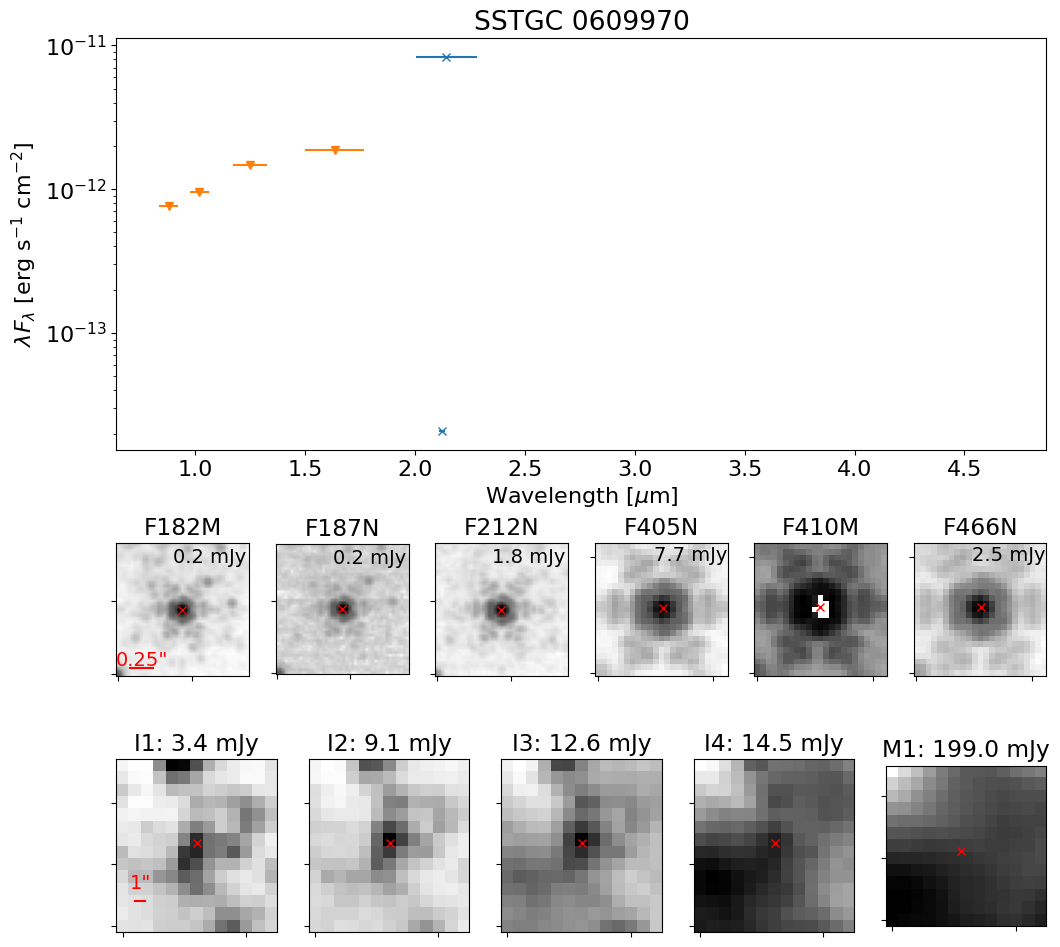

In [105]:
triplot(12)

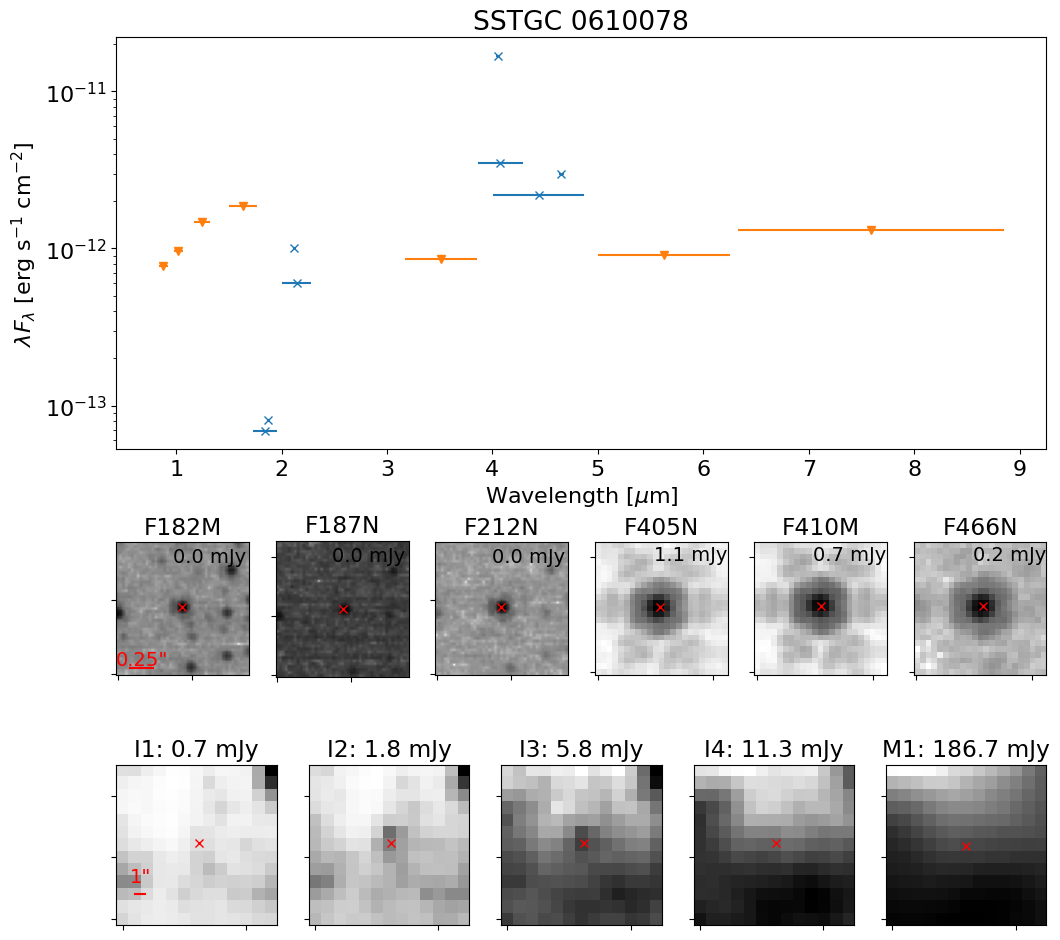

In [106]:
triplot(13)

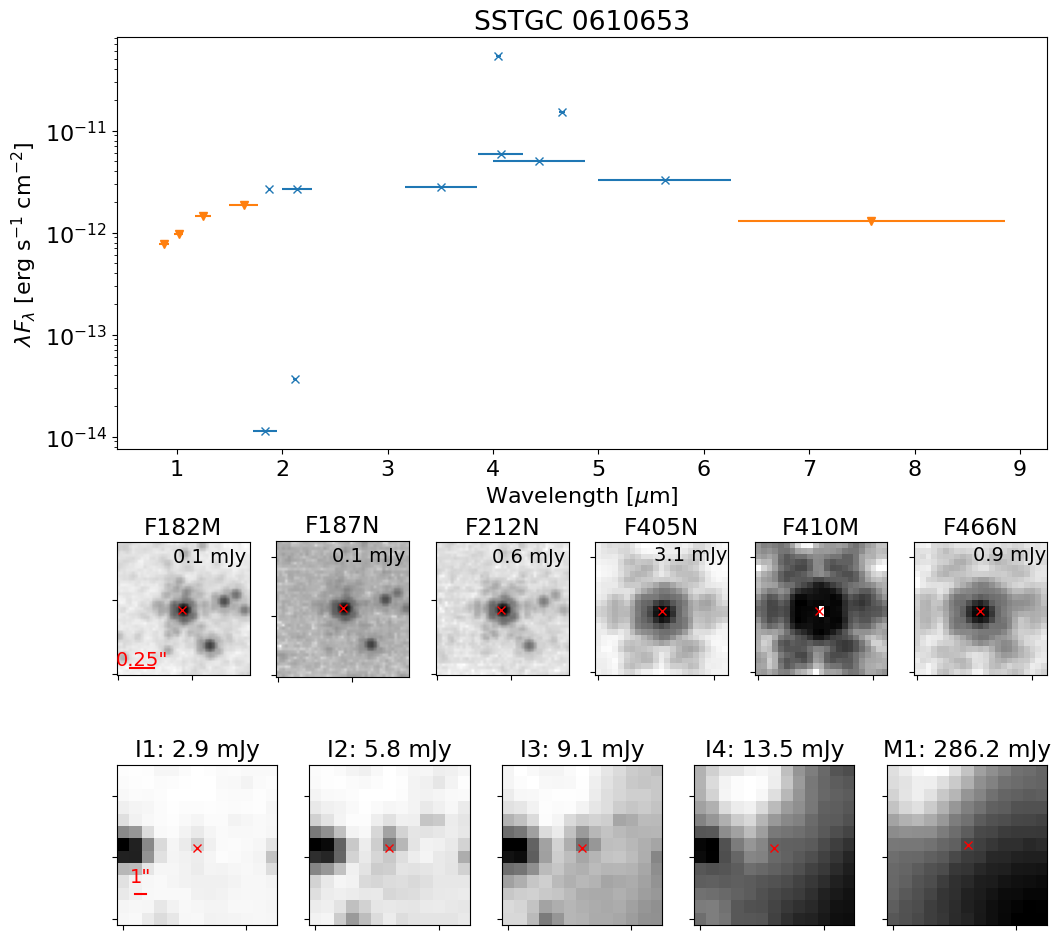

In [107]:
triplot(14)

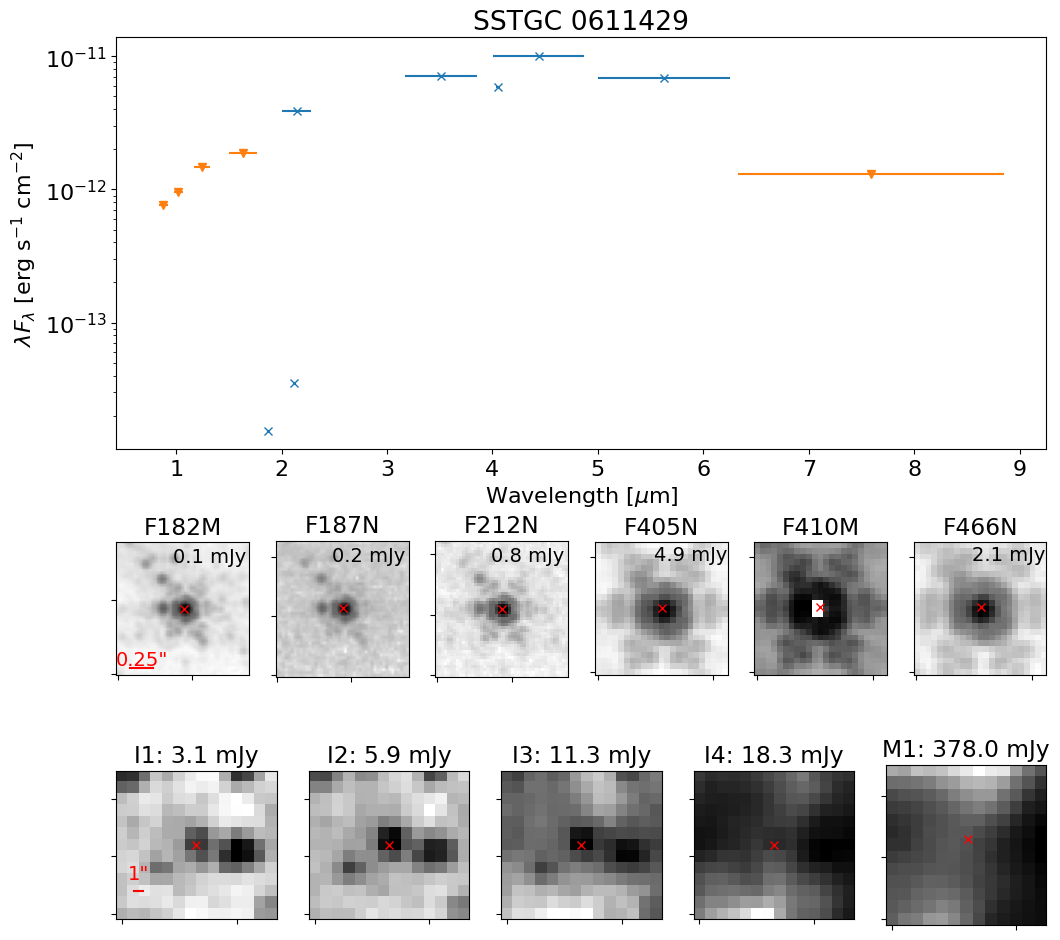

In [108]:
triplot(15)

INFO: No VVV match [plot_tools]


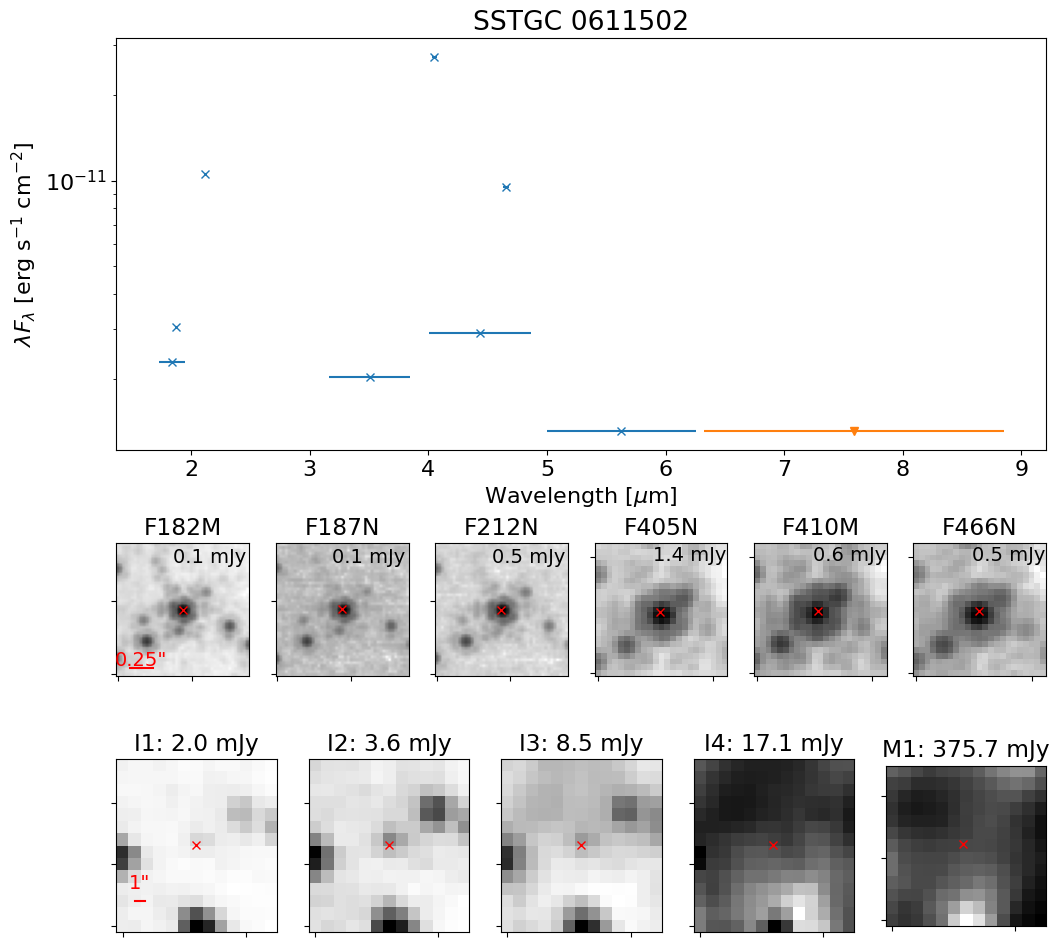

In [109]:
triplot(16)

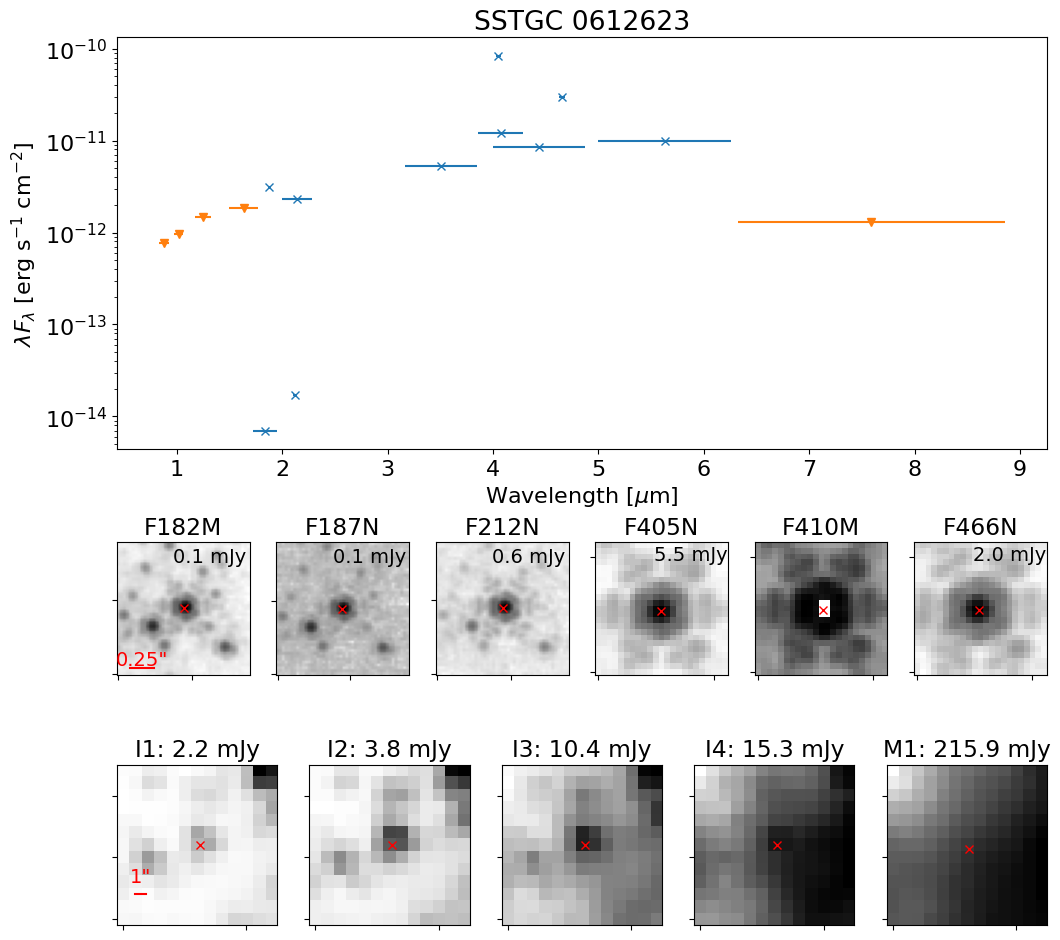

In [110]:
triplot(17)

INFO: No VVV match [plot_tools]


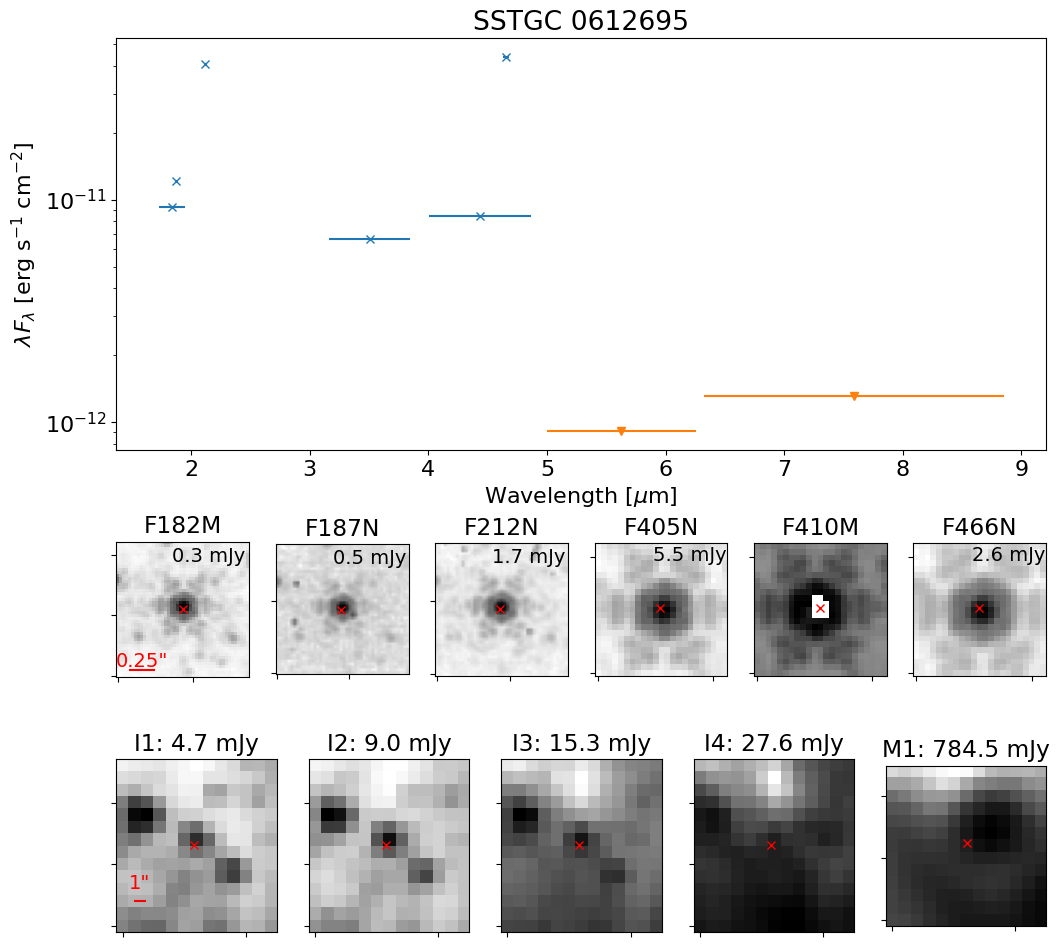

In [111]:
triplot(18)

INFO: No matches for spitzer: list index out of range [plot_tools]


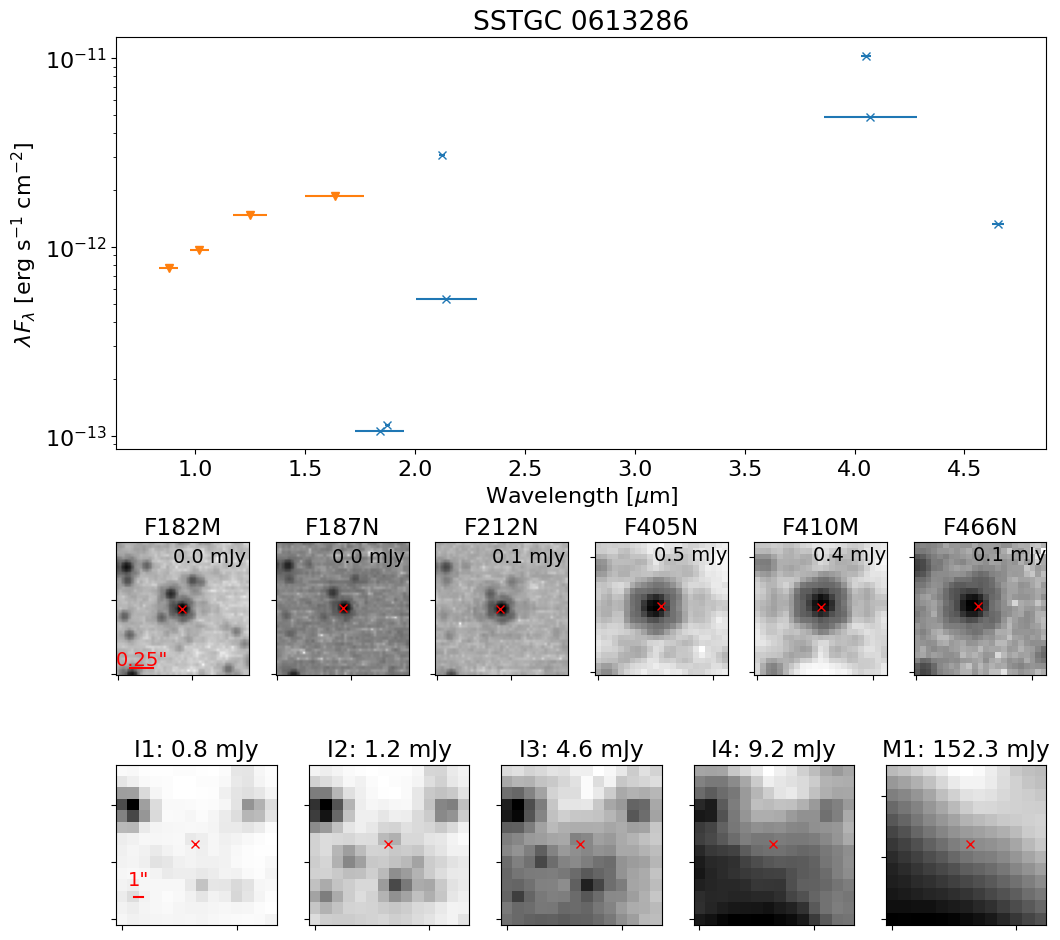

In [112]:
triplot(19)

INFO: No matches for spitzer: list index out of range [plot_tools]


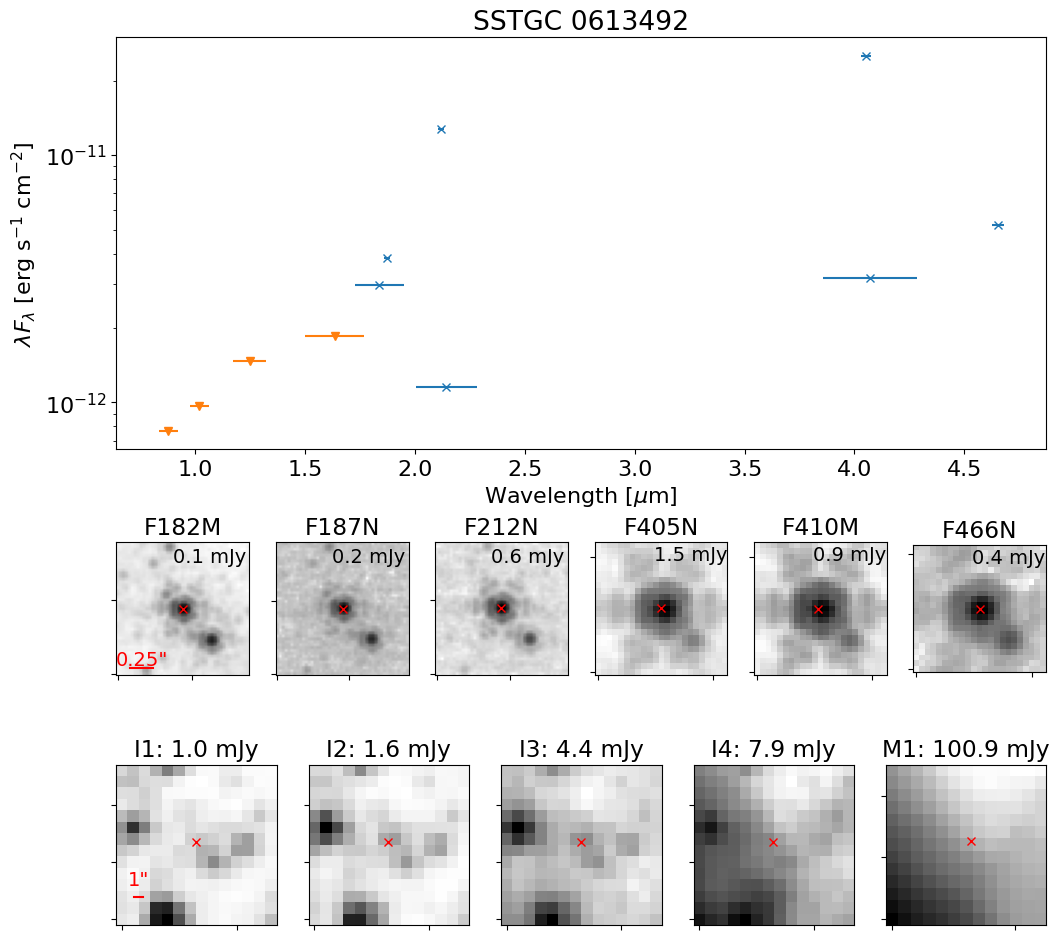

In [113]:
triplot(20)

INFO: No VVV match [plot_tools]


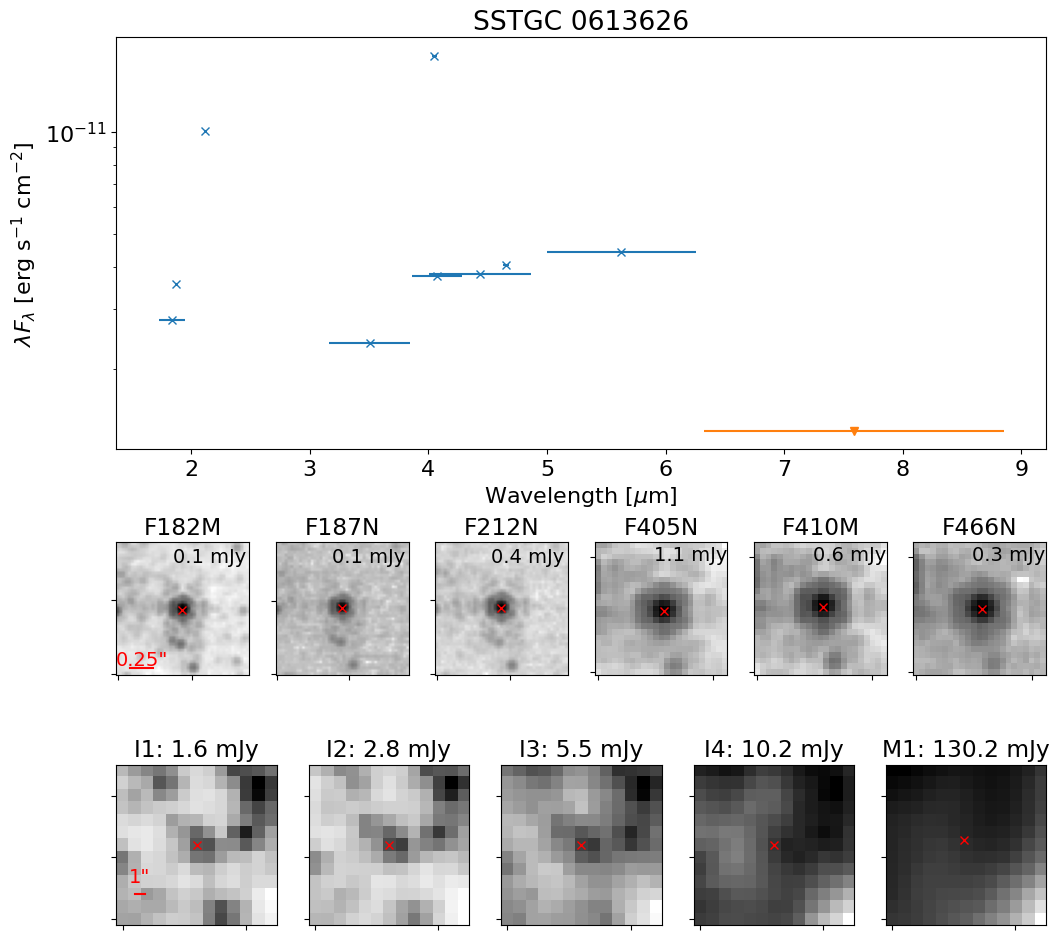

In [114]:
triplot(21)

INFO: No matches for spitzer: list index out of range [plot_tools]


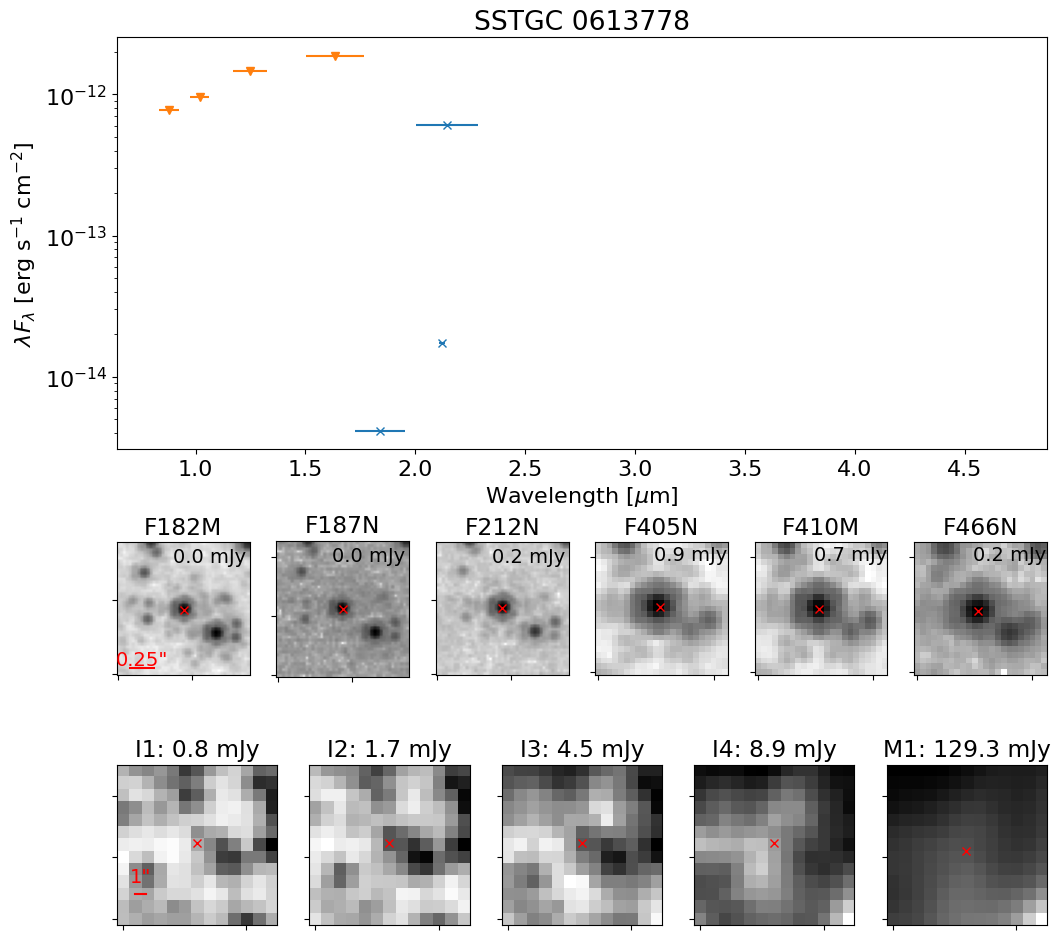

In [115]:
triplot(22)

INFO: No matches for spitzer: list index out of range [plot_tools]
INFO: No VVV match [plot_tools]


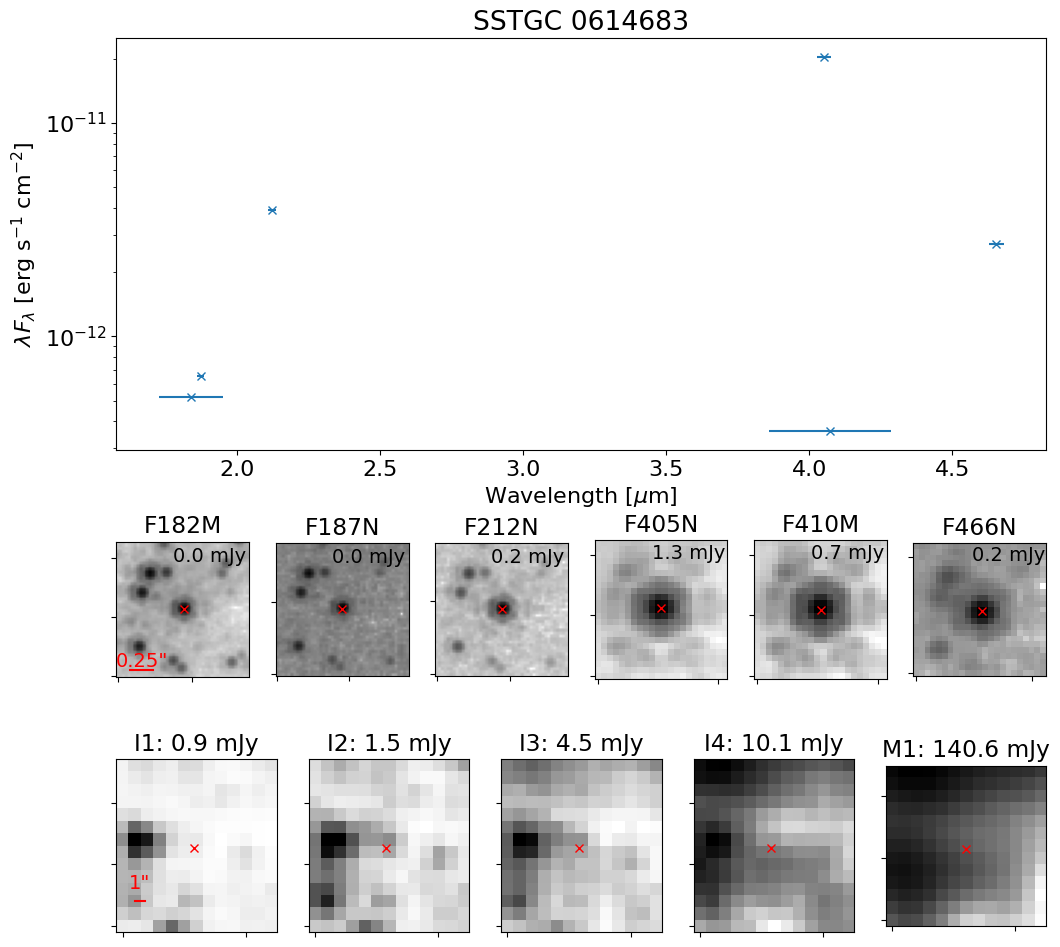

In [116]:
triplot(23)

Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.651775 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526292809.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


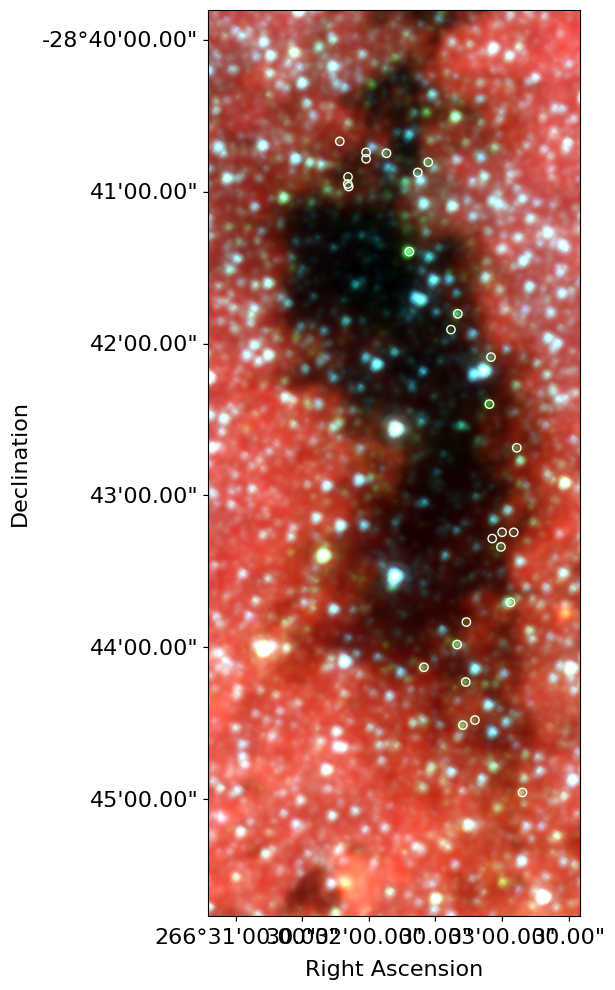

In [117]:
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickSpitzer_RGB_I421.png')
img_spitzer = np.array(PIL.Image.open(f'{basepath}/images/BrickSpitzer_RGB_I421.png'))[::-1,:,:]
wwi_spitzer_unflip = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

img_spitzer = img_spitzer.swapaxes(0,1)
wwi_spitzer = wwi_spitzer_unflip.sub([2,1])

fig = pl.figure(figsize=(12,12))
ax = pl.subplot(projection=wwi_spitzer)
ax.imshow(img_spitzer)
axlims = ax.axis()

xx,yy = wwi_spitzer.world_to_pixel(greenstarregcenters)
ax.scatter(
    xx,yy,
    #spitzer_crds.ra[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #spitzer_crds.dec[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #transform=ax.get_transform('fk5'),
    marker='o', edgecolors='w', facecolors='none',
    #markeredgewidth=0.5,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), a 
);

#ax.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))
ax.coords['ra'].set_axislabel('Right Ascension')
ax.coords['dec'].set_axislabel('Declination')

ra = lon = ax.coords['ra']
dec = lat = ax.coords['dec']
lon.set_major_formatter('dd:mm:ss.ss')
lat.set_major_formatter('dd:mm:ss.ss')
#lon.set_ticks(spacing=30. * u.arcsec, color='red')
#lat.set_ticks(spacing=30. * u.arcsec, color='blue')
#lon.set_ticklabel(color='red')
#lat.set_ticklabel(color='blue')
#lon.grid(color='red')
#lat.grid(color='blue')

ax.axis(axlims)

dec.set_ticks_position('l')
dec.set_ticklabel_position('l')
dec.set_axislabel_position('l')
ra.set_ticks_position('b')
ra.set_ticklabel_position('b')
ra.set_axislabel_position('b')
#fig.savefig(f"{basepath}/images/BlueStarsWithSpitzerMatches_on_RGB.png", bbox_inches='tight')

In [118]:
spitzer[:1]

<Table length=1>
 SSTGC    RAJ2000     DEJ2000     Jmag    Hmag    Ksmag   _3.6mag _4.5mag _5.8mag _8.0mag IRAC _2M           coordinates          
                                  mag     mag      mag      mag     mag     mag     mag                        deg,deg            
  str7     str11       str11    float32 float32  float32  float32 float32 float32 float32 str4 str2            SkyCoord           
------- ----------- ----------- ------- -------- -------- ------- ------- ------- ------- ---- ---- ------------------------------
0587868 17 46 02.85 -28 40 12.2  16.356   12.092   10.268   8.880   8.877   8.521   8.613 IRAC   2M 266.511875,-28.670055555555557

In [119]:
basetable[:2]

<Table length=2>
             skycoord_ref              sep_f410m id_f410m             skycoord_f410m                  x_f410m            y_f410m       flux_f410m passno_f410m ... mag_ab_410m405 flux_jy_405m410 mag_ab_405m410 flux_jy_182m187 mag_ab_182m187 flux_jy_187m182 mag_ab_187m182
               deg,deg                    deg                            deg,deg                                                                               ...                       Jy                             Jy                             Jy                     
               SkyCoord                 float64   int64                  SkyCoord                     float64            float64        float32     float64    ...    float32         float32        float32         float32        float32         float32        float32    
-------------------------------------- --------- -------- -------------------------------------- ------------------ ------------------ ---------- ------------ ... -------------- --------------- -------------- --------------- -------------- --------------- --------------
  266.5132295512658,-28.76224753283138       0.0        0   266.5132295512658,-28.76224753283138 29.421751022338867 2.1528244018554688   271998.5          0.0 ...      10.274287              --             --   4.3584998e-05      19.801657   5.1613035e-05      19.618101
266.51317652848337,-28.762242974512606       0.0        1 266.51317652848337,-28.762242974512606  29.72231674559422             -0.499  1276332.1          0.0 ...       8.596677              --       9.170473              --      20.211143              --       18.95343

In [120]:
SvoFps.get_filter_list(facility="JWST", instrument="NIRCAM")[:1]

<Table length=1>
FilterProfileService      filterID     WavelengthUnit WavelengthUCD PhotSystem DetectorType  Band  Instrument Facility ...       PhotCalID        MagSys    ZeroPoint    ZeroPointUnit   Mag0  ZeroPointType AsinhSoft                            TrasmissionCurve                          
                                                                                                                       ...                                      Jy                                                                                                                          
       object              object          object         object      object      object    object   object    object  ...         object         object     float64         object    float64     object     float64                                  object                               
-------------------- ----------------- -------------- ------------- ---------- ------------ ------ ---------- -------- ... ---------------------- ------ --------------- ------------- ------- ------------- --------- ---------------------------------------------------------------------
       ivo://svo/fps JWST/NIRCam.F070W       Angstrom         em.wl     NIRCam            1            NIRCam     JWST ... JWST/NIRCam.F070W/Vega   Vega 2768.4045696982            Jy     0.0        Pogson       0.0 http://svo2.cab.inta-csic.es//theory/fps/fps.php?ID=JWST/NIRCam.F070W

# not (yet) used: VVV and Spitzer color comparisons

In [121]:
vvvdr2 = Vizier.query_region(coordinates=coord, width=width, height=height, catalog=['II/348/vvv2'])[0]
vvvdr2_crds = SkyCoord(vvvdr2['RAJ2000'], vvvdr2['DEJ2000'], frame='fk5')
idx, sidx, sep, sep3d = vvvdr2_crds.search_around_sky(skycrds_cat, 0.2*u.arcsec)

twomass_crds = SkyCoord(twomass['RAJ2000'], twomass['DEJ2000'], frame='fk5')

In [122]:
spitzer[:10]

<Table length=10>
 SSTGC    RAJ2000     DEJ2000     Jmag    Hmag    Ksmag   _3.6mag _4.5mag _5.8mag _8.0mag IRAC _2M               coordinates              
                                  mag     mag      mag      mag     mag     mag     mag                            deg,deg                
  str7     str11       str11    float32 float32  float32  float32 float32 float32 float32 str4 str2                SkyCoord               
------- ----------- ----------- ------- -------- -------- ------- ------- ------- ------- ---- ---- --------------------------------------
0587868 17 46 02.85 -28 40 12.2  16.356   12.092   10.268   8.880   8.877   8.521   8.613 IRAC   2M         266.511875,-28.670055555555557
0587987 17 46 02.88 -28 40 56.9      --       --       --  11.862  11.750  11.650      -- IRAC   2M            266.512,-28.682472222222223
0588048 17 46 02.91 -28 41 10.7  16.354   13.242   11.082   9.990   9.987   9.204   8.947 IRAC   2M  266.5121249999999,-28.686305555555556
0588049 17 46 02.91 -28 41 20.5  15.151   13.292   11.662      --      --      --      -- IRAC   2M  266.5121249999999,-28.689027777777778
0588072 17 46 02.92 -28 40 51.0  16.289   13.174   11.558  10.455  10.306  10.410      -- IRAC   2M 266.51216666666664,-28.680833333333336
0588192 17 46 02.96 -28 40 34.4      --       --       --  11.804  11.215  10.388      -- IRAC   2M  266.5123333333333,-28.676222222222222
0588205 17 46 02.97 -28 41 17.4  15.686   13.187   12.083  10.381  10.213   9.779      -- IRAC   2M 266.51237499999996,-28.688166666666667
0588263 17 46 02.99 -28 42 13.3  15.949   11.427    9.056   7.284   7.041   6.496   6.504 IRAC   2M  266.5124583333333,-28.703694444444444
0588346 17 46 03.02 -28 42 47.6  17.364   13.131   11.479  10.095      --      --      -- IRAC   2M   266.5125833333333,-28.71322222222222
0588403 17 46 03.04 -28 39 48.7  16.565   13.542   12.506  11.155  11.263  10.735      -- IRAC   2M  266.5126666666666,-28.663527777777777

# An2011 Vizier

In [123]:
an2011 = Vizier(row_limit=500).get_catalogs(['J/ApJ/736/133/table1'])[0]

In [124]:
an2011crds = SkyCoord(an2011['RAJ2000'], an2011['DEJ2000'], frame='fk5', unit=(u.h, u.deg))

In [125]:
an2011[wwi_spitzer.footprint_contains(an2011crds)]

<Table length=3>
SSTGC   Y     RAJ2000     DEJ2000      Date      Us  F02  S06  Y09  f_Y09 YSOcat
                                     'Y:M:D'                                    
int32  str1    str11       str11      str10     str5 str3 str3 str3  str1 int16 
------ ---- ----------- ----------- ---------- ----- ---- ---- ---- ----- ------
600274      17 46 07.39 -28 45 32.0 2008-05-01    no                           0
618018    Y 17 46 13.81 -28 43 44.5 2008-05-01 maybe  yes                      1
619522    Y 17 46 14.33 -28 43 18.4 2008-05-01 maybe                           0

Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.651775 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526292809.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


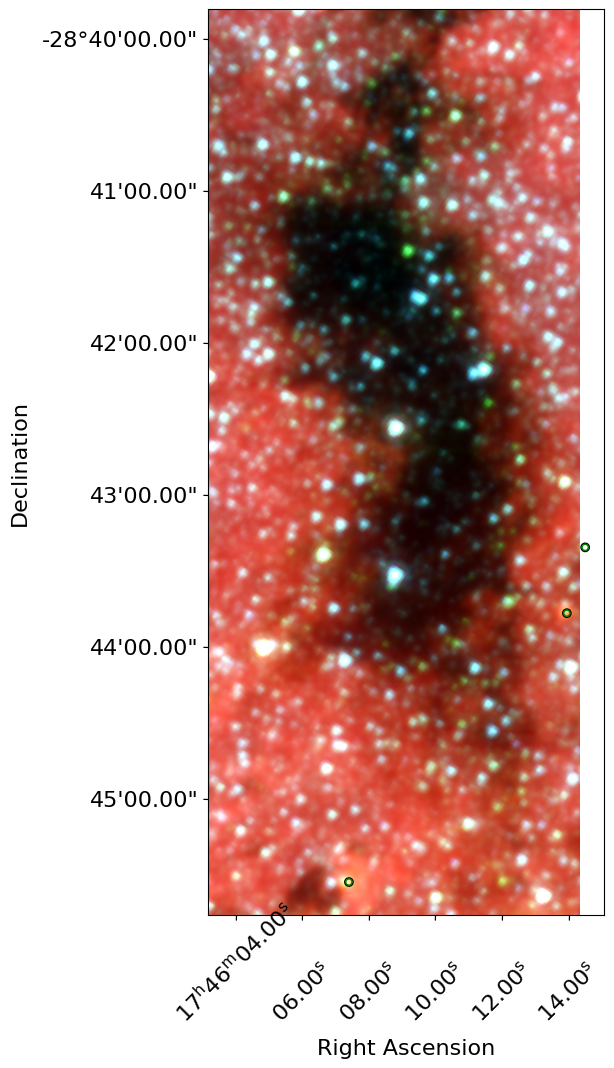

In [126]:
# This image shows only H-alpha stars
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickSpitzer_RGB_I421.png')
img_spitzer = np.array(PIL.Image.open(f'{basepath}/images/BrickSpitzer_RGB_I421.png'))[::-1,:,:]
#wwi_bra_410 = avm.to_wcs(use_full_header=True)
wwi_spitzer = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

img_spitzer = img_spitzer.swapaxes(0,1)
wwi_spitzer = wwi_spitzer.sub([2,1])

fig = pl.figure(figsize=(12,12))
ax = pl.subplot(projection=wwi_spitzer)
ax.imshow(img_spitzer)
axlims = ax.axis()

xx,yy = wwi_spitzer.world_to_pixel(an2011crds[wwi_spitzer.footprint_contains(an2011crds)])
ax.scatter(
    xx,yy,
    #spitzer_crds.ra[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #spitzer_crds.dec[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #transform=ax.get_transform('fk5'),
    marker='o', edgecolors='black', facecolors='none',
    #markeredgewidth=0.5,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), a 
);
ax.scatter(
    xx,yy,
    s=20,
    marker='o', edgecolors='g', facecolors='none',
);
#ax.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))
ax.coords['ra'].set_axislabel('Right Ascension')
ax.coords['dec'].set_axislabel('Declination')

ra = lon = ax.coords['ra']
dec = lat = ax.coords['dec']
lon.set_major_formatter('hh:mm:ss.ss')
lat.set_major_formatter('dd:mm:ss.ss')
lon.set_ticks(spacing=30. * u.arcsec)
lon.set_ticklabel(rotation=45, pad=60)
#lat.set_ticks(spacing=30. * u.arcsec, color='blue')



#ax.axis(axlims)

dec.set_ticks_position('l')
dec.set_ticklabel_position('l')
dec.set_axislabel_position('l')
ra.set_ticks_position('b')
ra.set_ticklabel_position('b')
ra.set_axislabel_position('b')
#fig.savefig(f"{basepath}/images/BlueStarsWithSpitzerMatches_on_RGB.png", bbox_inches='tight')

# make CCDs/CMDs highlighting the green stars

also show the stars with nondetections in one or more bands

In [127]:
spitzer_crds

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    [(266.511875  , -28.67005556), (266.512     , -28.68247222),
     (266.512125  , -28.68630556), ..., (266.559125  , -28.75655556),
     (266.55929167, -28.74422222), (266.55933333, -28.75097222)]>

In [128]:
inds_green, rev_inds, sep, sep3d = greenstarregcenters.search_around_sky(spitzer_crds, 2*u.arcsec)
inds_green

array([438, 467, 467, 561, 638, 639, 698, 710, 786, 804, 815, 820, 824,
       828, 849, 878, 881, 921, 923, 948, 954, 960, 969, 999])

(array([ 2.,  3.,  9., 16., 61., 50., 47., 17.,  4.,  1.]),
 array([ 5.02799988,  5.70580006,  6.38359976,  7.06139994,  7.73919964,
         8.41699982,  9.0948    ,  9.77260017, 10.4503994 , 11.12819958,
        11.80599976]),
 <BarContainer object of 10 artists>)

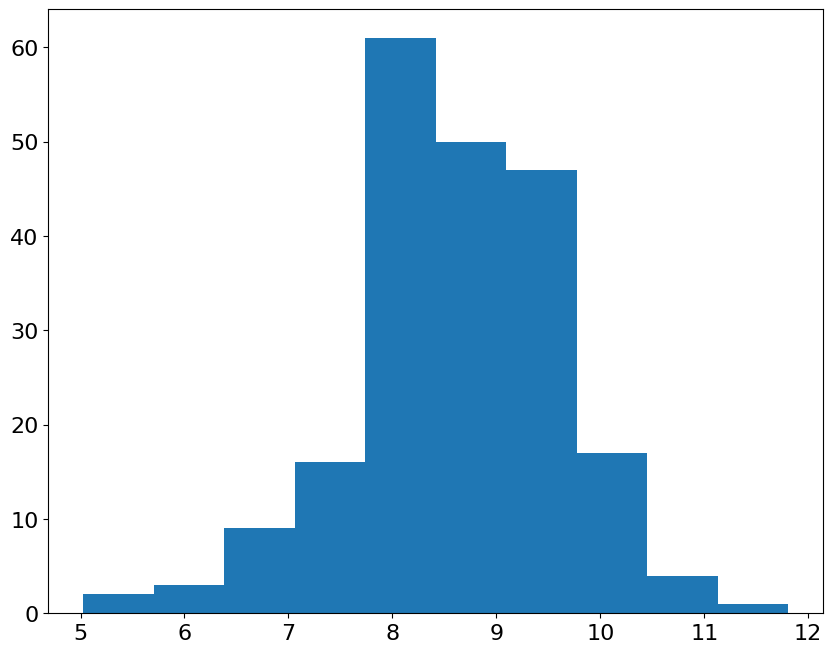

In [129]:
pl.hist(spitzer['_8.0mag'])

In [130]:
i4lim = np.nanpercentile(np.array(spitzer['_8.0mag']), 99)
i3lim = np.nanpercentile(np.array(spitzer['_5.8mag']), 99)
i2lim = np.nanpercentile(np.array(spitzer['_4.5mag']), 99)
i1lim = np.nanpercentile(np.array(spitzer['_3.6mag']), 99)
i1lim, i2lim, i3lim, i4lim

(13.594460010528564, 13.034479751586915, 12.056260299682616, 10.70722972869873)

In [131]:
spitzer[inds_green]

<Table length=24>
 SSTGC    RAJ2000     DEJ2000     Jmag    Hmag    Ksmag   _3.6mag _4.5mag _5.8mag _8.0mag IRAC _2M               coordinates              
                                  mag     mag      mag      mag     mag     mag     mag                            deg,deg                
  str7     str11       str11    float32 float32  float32  float32 float32 float32 float32 str4 str2                SkyCoord               
------- ----------- ----------- ------- -------- -------- ------- ------- ------- ------- ---- ---- --------------------------------------
0598847 17 46 06.78 -28 40 39.0      --       --       --  12.946  11.886      --      -- IRAC   2M 266.52824999999996,-28.677500000000002
0599587 17 46 07.07 -28 40 56.9      --       --       --  12.482  11.245  10.340      -- IRAC   2M 266.52945833333325,-28.682472222222223
0599587 17 46 07.07 -28 40 56.9      --       --       --  12.482  11.245  10.340      -- IRAC   2M 266.52945833333325,-28.682472222222223
0602602 17 46 08.16 -28 40 43.6  16.273   13.814   12.494      --  10.552  10.480      -- IRAC   2M             266.534,-28.67877777777778
0604690 17 46 08.93 -28 41 21.4  15.771   14.528   12.425      --      --      --      -- IRAC   2M  266.53720833333324,-28.68927777777778
0604691 17 46 08.93 -28 41 22.5  15.819   14.663   12.374  10.953   8.864   8.285   8.895 IRAC   2M 266.53720833333324,-28.689583333333335
0606141 17 46 09.44 -28 40 47.1      --       --       --      --  10.850  10.694      -- IRAC   2M  266.5393333333333,-28.679750000000002
0606434 17 46 09.55 -28 44 06.7  17.987   16.060   13.938  11.613  10.375   9.454      -- IRAC   2M 266.53979166666664,-28.735194444444446
0608824 17 46 10.40 -28 41 46.9      --       --       --  11.249  10.005   9.539   9.555 IRAC   2M  266.5433333333333,-28.696361111111113
0609360 17 46 10.61 -28 43 57.6      --       --       --  11.303  10.027   9.539      -- IRAC   2M  266.5442083333333,-28.732666666666663
0609782 17 46 10.76 -28 44 29.4      --       --       --  11.297  10.195   9.861      -- IRAC   2M  266.5448333333333,-28.741500000000002
0609907 17 46 10.81 -28 43 48.5      --       --       --      --  11.851      --      -- IRAC   2M 266.54504166666663,-28.730138888888888
0609970 17 46 10.83 -28 44 12.0      --       --       --  12.302  10.951  10.660      -- IRAC   2M         266.545125,-28.736666666666668
0610078 17 46 10.87 -28 44 28.5  15.417   14.470   12.613      --      --      --      -- IRAC   2M            266.5452916666666,-28.74125
0610653 17 46 11.09 -28 44 27.3      --       --       --  12.657  11.538  11.659      -- IRAC   2M  266.5462083333333,-28.740916666666667
0611429 17 46 11.38 -28 42 21.8      --       --       --  12.633  10.324   9.632      -- IRAC   2M  266.5474166666666,-28.706055555555555
0611502 17 46 11.40 -28 42 03.7      --       --       --      --  10.668      --      -- IRAC   2M 266.54749999999996,-28.701027777777778
0612623 17 46 11.81 -28 43 18.4      --       --       --      --  11.226  10.707      -- IRAC   2M  266.5492083333333,-28.721777777777778
0612695 17 46 11.83 -28 43 12.8      --       --       --      --  12.083  12.994      -- IRAC   2M  266.54929166666665,-28.72022222222222
0613286 17 46 12.06 -28 43 40.5  16.675   13.853   11.691   9.939   8.685   8.225      -- IRAC   2M 266.55024999999995,-28.727916666666665
0613492 17 46 12.13 -28 43 40.8      --       --       --      --      --      --   8.488 IRAC   2M  266.5505416666666,-28.727999999999998
0613626 17 46 12.18 -28 43 12.6      --       --       --      --  12.423      --      -- IRAC   2M 266.55074999999994,-28.720166666666664
0613778 17 46 12.24 -28 42 39.6      --       --       --  12.390      --      --      -- IRAC   2M             266.55099999999993,-28.711
0614683 17 46 12.57 -28 44 55.5      --       --       --  11.367  10.384      --      -- IRAC   2M            266.5523749999999,-28.74875

Text(0, 0.5, 'I2-I4')

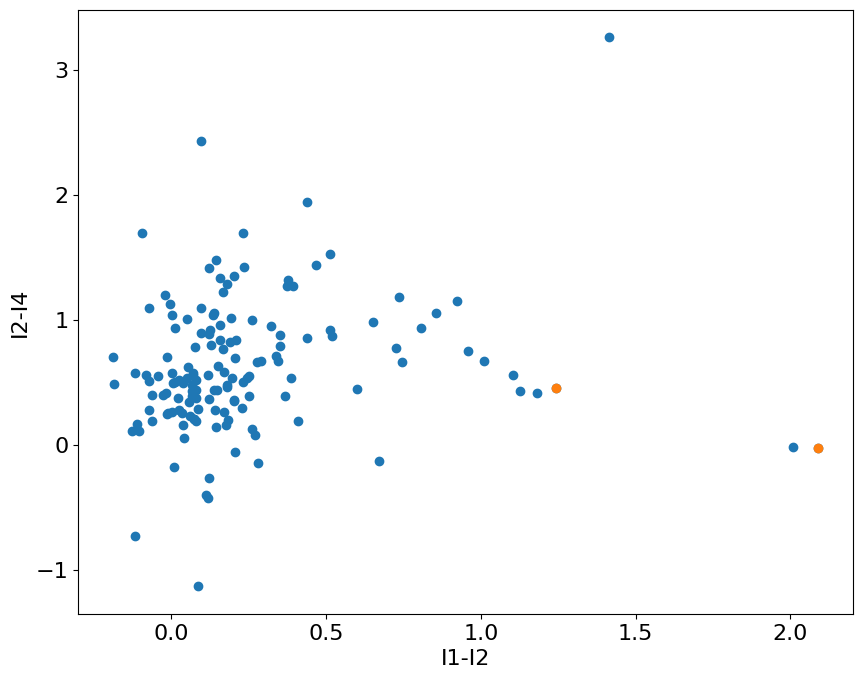

In [132]:
pl.scatter(spitzer['_3.6mag'] - spitzer['_4.5mag'],  spitzer['_4.5mag'] - spitzer['_8.0mag'])
pl.scatter(spitzer['_3.6mag'][inds_green] - spitzer['_4.5mag'][inds_green],  spitzer['_4.5mag'][inds_green] - spitzer['_8.0mag'][inds_green])
pl.xlabel("I1-I2")
pl.ylabel("I2-I4")

From SED inspection, done below, it is common to have I3 detection but I4 nondetection

Text(0, 0.5, 'I2-I3')

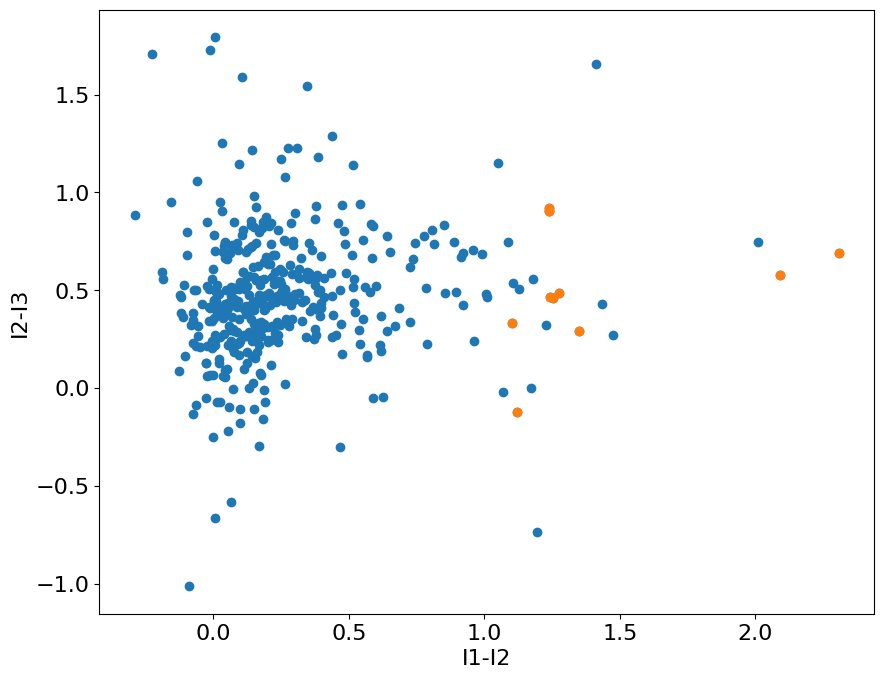

In [136]:
pl.scatter(spitzer['_3.6mag'] - spitzer['_4.5mag'],  spitzer['_4.5mag'] - spitzer['_5.8mag'])
pl.scatter(spitzer['_3.6mag'][inds_green] - spitzer['_4.5mag'][inds_green],  spitzer['_4.5mag'][inds_green] - spitzer['_5.8mag'][inds_green])
pl.xlabel("I1-I2")
pl.ylabel("I2-I3")

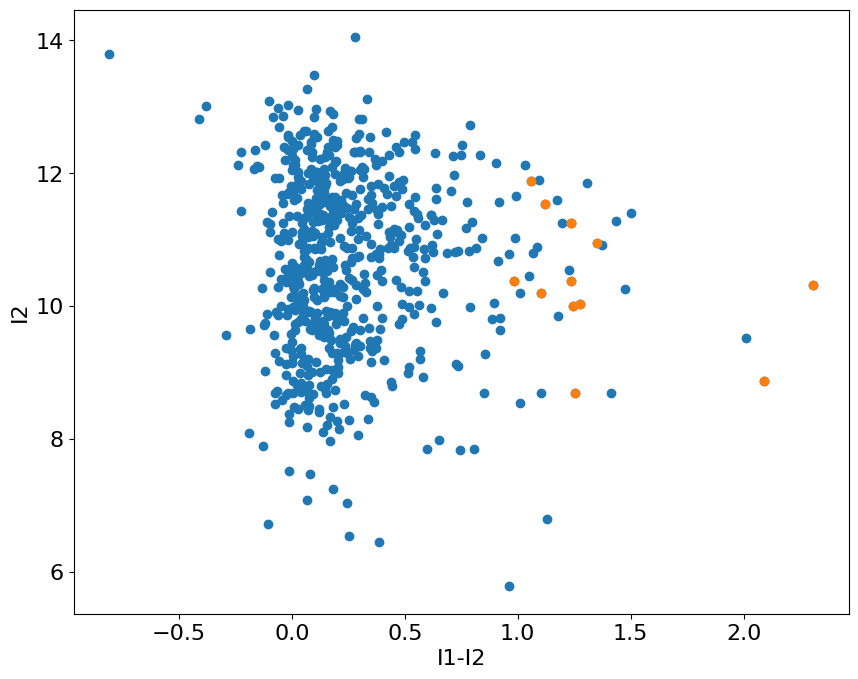

In [137]:
pl.scatter(spitzer['_3.6mag'] - spitzer['_4.5mag'],  spitzer['_4.5mag'] )
pl.scatter(spitzer['_3.6mag'][inds_green] - spitzer['_4.5mag'][inds_green],  spitzer['_4.5mag'][inds_green])
pl.xlabel("I1-I2")
pl.ylabel("I2");

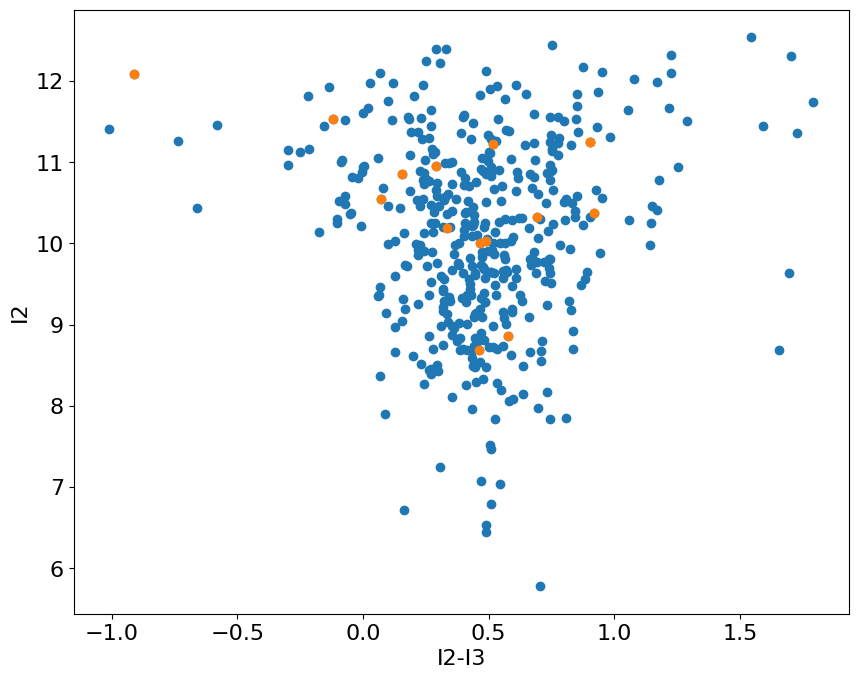

In [139]:
pl.scatter(-spitzer['_5.8mag'] + spitzer['_4.5mag'],  spitzer['_4.5mag'] )
pl.scatter(-spitzer['_5.8mag'][inds_green] + spitzer['_4.5mag'][inds_green],  spitzer['_4.5mag'][inds_green])
pl.xlabel("I2-I3")
pl.ylabel("I2");

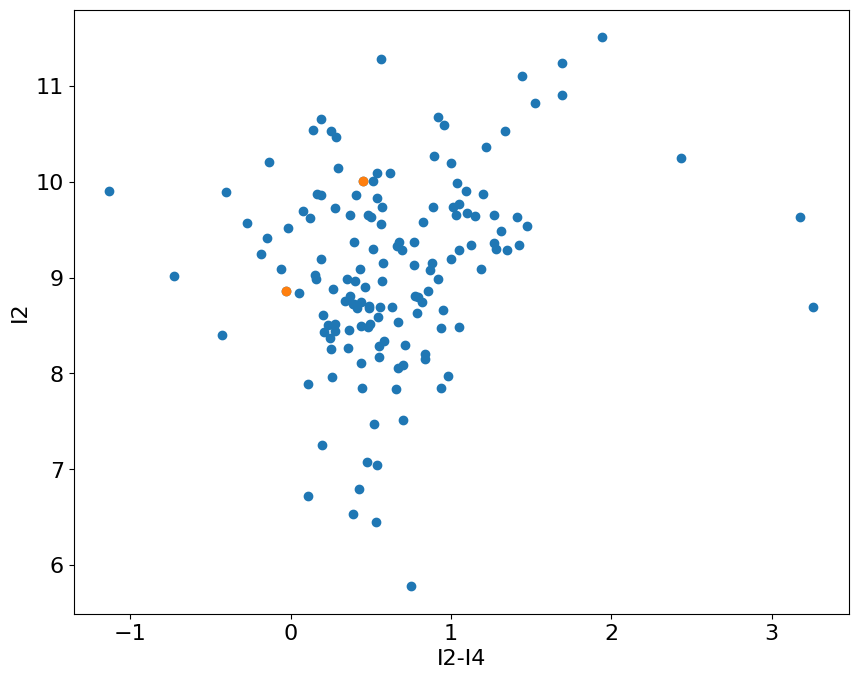

In [140]:
pl.scatter(-spitzer['_8.0mag'] + spitzer['_4.5mag'],  spitzer['_4.5mag'] )
pl.scatter(-spitzer['_8.0mag'][inds_green] + spitzer['_4.5mag'][inds_green],  spitzer['_4.5mag'][inds_green])
pl.xlabel("I2-I4")
pl.ylabel("I2");

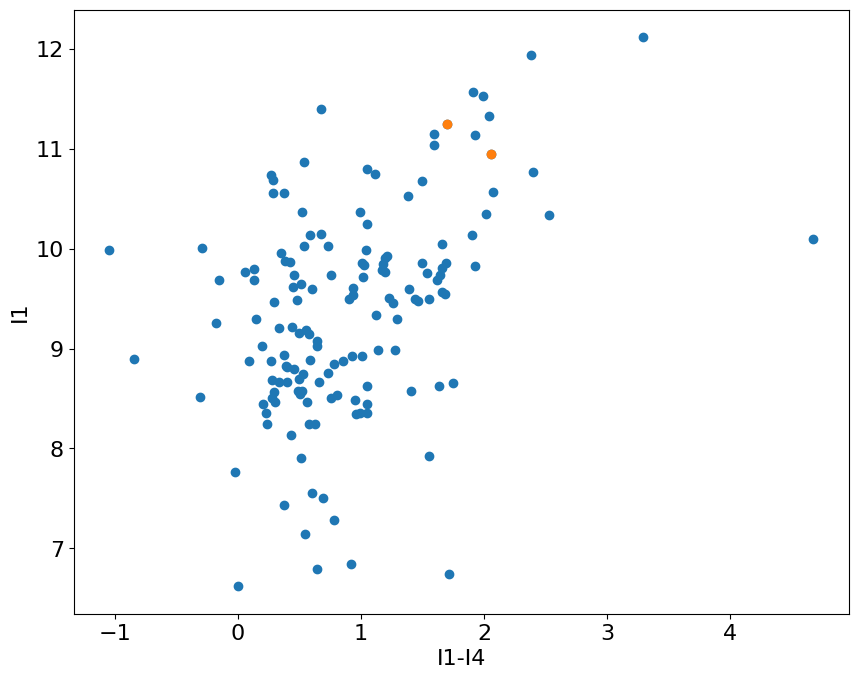

In [141]:
pl.scatter(-spitzer['_8.0mag'] + spitzer['_3.6mag'],  spitzer['_3.6mag'] )
pl.scatter(-spitzer['_8.0mag'][inds_green] + spitzer['_3.6mag'][inds_green],  spitzer['_3.6mag'][inds_green])
pl.xlabel("I1-I4")
pl.ylabel("I1");

In [138]:
len(inds_green)

24

## Try some other color cuts

In [133]:
green_spitzer = (np.array(spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0.5) |
                 (np.array(spitzer['_4.5mag'] - spitzer['_5.8mag'] < 0.0)))
green_nored = np.array((spitzer['_4.5mag'] < i2lim-1) & (spitzer['_8.0mag'].mask))
redI1I2 = ((np.array(spitzer['_3.6mag'] - spitzer['_4.5mag'] > 1)) |
           (np.array(spitzer['_3.6mag'].mask & ~spitzer['_4.5mag'].mask)))
reddish_i1i2_spitzer_and_greeni2i4 = (redI1I2 &
                                      (green_nored | green_spitzer)
                                      & wwi_spitzer_unflip.footprint_contains(spitzer_crds)
                                     )
reddish_i1i2_spitzer_and_greeni2i4.sum()

77

Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.651775 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526292809.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


These #'s should be equal: 77 77


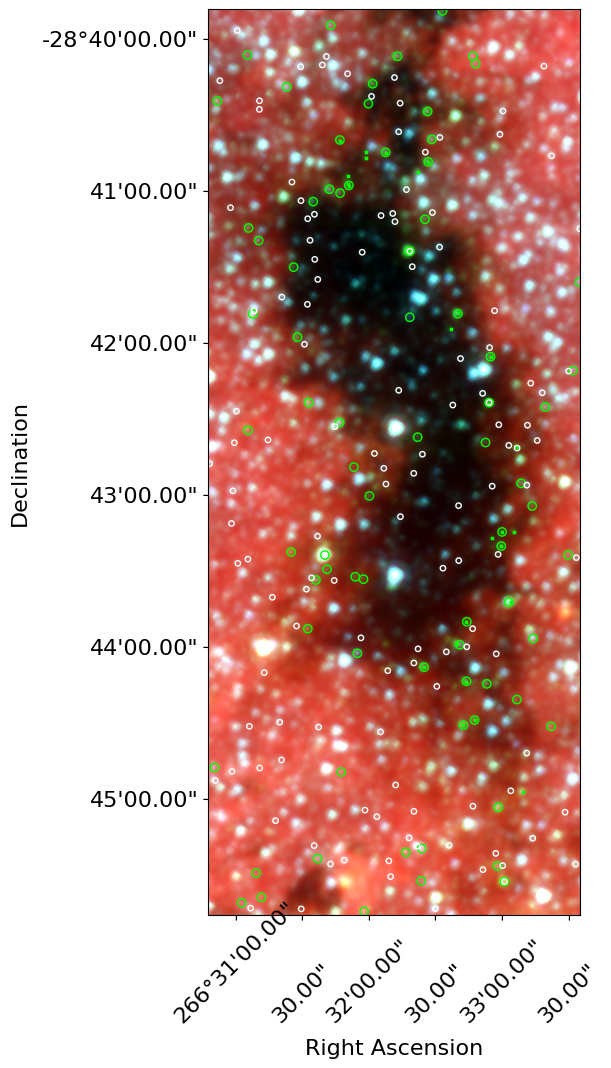

In [145]:
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickSpitzer_RGB_I421.png')
img_spitzer = np.array(PIL.Image.open(f'{basepath}/images/BrickSpitzer_RGB_I421.png'))[::-1,:,:]
#wwi_bra_410 = avm.to_wcs(use_full_header=True)
wwi_spitzer_unflip = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

img_spitzer = img_spitzer.swapaxes(0,1)
wwi_spitzer = wwi_spitzer_unflip.sub([2,1])

fig = pl.figure(figsize=(12,12))
ax = pl.subplot(projection=wwi_spitzer)
ax.imshow(img_spitzer)
axlims = ax.axis()

green_spitzer = np.array(spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0.)
green_nored = np.array((spitzer['_4.5mag'] < 10) & (spitzer['_8.0mag'].mask))
xx,yy = wwi_spitzer.world_to_pixel(spitzer_crds[reddish_i1i2_spitzer_and_greeni2i4])
print("These #'s should be equal:", reddish_i1i2_spitzer_and_greeni2i4.sum(), len(xx))
ax.scatter(
    xx,yy,
    #spitzer_crds.ra[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #spitzer_crds.dec[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #transform=ax.get_transform('fk5'),
    marker='o', edgecolors='lime', facecolors='none',
    #markeredgewidth=0.5,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), a 
);
xx,yy = wwi_spitzer.world_to_pixel(greenstarregcenters)
ax.scatter(xx, yy, marker='x', s=4, color='lime')
#xx,yy = wwi_spitzer.world_to_pixel(spitzer_crds[green_nored])
#ax.scatter(
#    xx,yy,
#    marker='o', edgecolors='b', facecolors='none',
#);
redi1i2_spitzer = (spitzer['_3.6mag'] - spitzer['_4.5mag'] > 1.75)# | ((10 < spitzer['_4.5mag']) & (spitzer['_4.5mag'] < 15) & (spitzer['_8.0mag'].mask))
xx,yy = wwi_spitzer.world_to_pixel(spitzer_crds[redi1i2_spitzer])
ax.scatter(
    xx,yy,
    #spitzer_crds.ra[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #spitzer_crds.dec[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #transform=ax.get_transform('fk5'),
    marker='o', edgecolors='w', facecolors='none',
s=15,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), a 
);
#ax.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))
ax.coords['ra'].set_axislabel('Right Ascension')
ax.coords['dec'].set_axislabel('Declination')

ra = lon = ax.coords['ra']
dec = lat = ax.coords['dec']
lon.set_major_formatter('dd:mm:ss.ss')
lat.set_major_formatter('dd:mm:ss.ss')
#lon.set_ticks(spacing=30. * u.arcsec, color='red')
#lat.set_ticks(spacing=30. * u.arcsec, color='blue')
#lon.set_ticklabel(color='red')
#lat.set_ticklabel(color='blue')
#lon.grid(color='red')
#lat.grid(color='blue')

ax.axis(axlims)

dec.set_ticks_position('l')
dec.set_ticklabel_position('l')
dec.set_axislabel_position('l')
ra.set_ticks_position('b')
ra.set_ticklabel_position('b')
ra.set_axislabel_position('b')
ra.set_ticklabel(rotation=45, pad=60)
#fig.savefig(f"{basepath}/images/BlueStarsWithSpitzerMatches_on_RGB.png", bbox_inches='tight')

Text(0, 0.5, 'I2-I4')

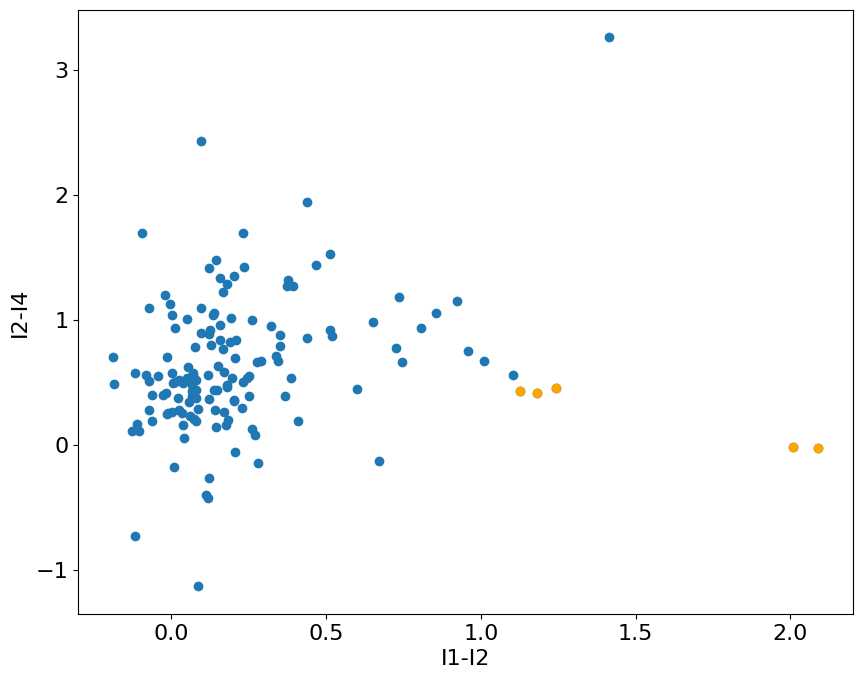

In [134]:
pl.scatter(spitzer['_3.6mag'] - spitzer['_4.5mag'],  spitzer['_4.5mag'] - spitzer['_8.0mag'])
pl.scatter((spitzer['_3.6mag'] - spitzer['_4.5mag'])[reddish_i1i2_spitzer_and_greeni2i4],
           (spitzer['_4.5mag'] - spitzer['_8.0mag'])[reddish_i1i2_spitzer_and_greeni2i4],
          color='orange')

pl.xlabel("I1-I2")
pl.ylabel("I2-I4")

In [97]:
(spitzer['_3.6mag'].mask & ~spitzer['_4.5mag'].mask).sum()

91

In [98]:
(~spitzer['_3.6mag'].mask & spitzer['_4.5mag'].mask).sum()

125

In [99]:
mag8mask = spitzer['_8.0mag'].mask
(reddish_i1i2_spitzer_and_greeni2i4 & mag8mask).sum()

72

(12.75515034198761, 5.447850203514099)

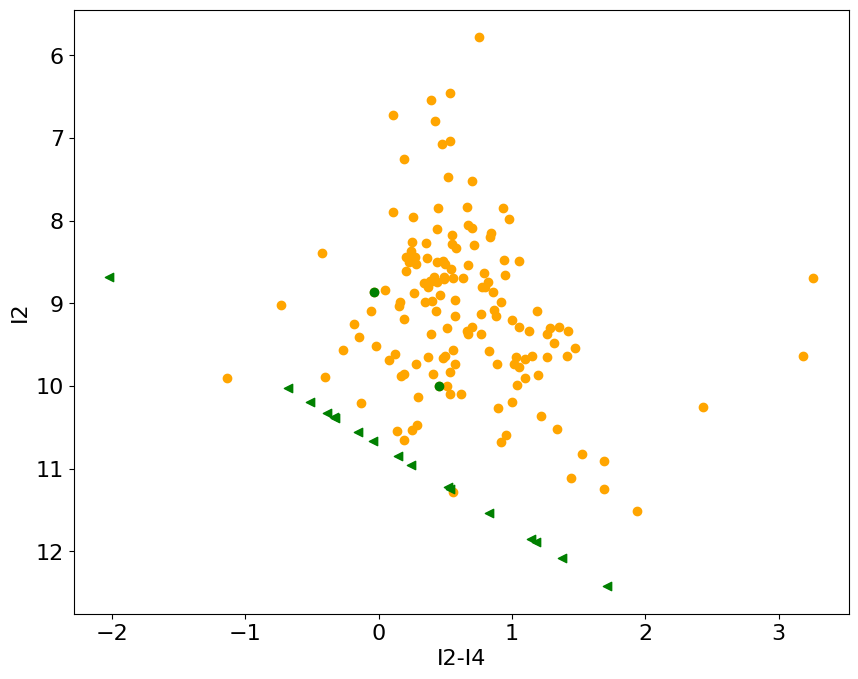

In [100]:
i4lim = np.nanpercentile(np.array(spitzer['_8.0mag']), 99)
pl.scatter(spitzer['_4.5mag'] - spitzer['_8.0mag'],  spitzer['_4.5mag'], color='orange')
#pl.scatter(spitzer['_4.5mag'][spitzer['_8.0mag'].mask] - i4lim,  spitzer['_4.5mag'][spitzer['_8.0mag'].mask])

mag8mask = spitzer['_8.0mag'].mask
greensrcmask = np.zeros_like(mag8mask, dtype='bool')
greensrcmask[inds_green] = True
pl.scatter(spitzer['_4.5mag'][inds_green] - spitzer['_8.0mag'][inds_green], 
           spitzer['_4.5mag'][inds_green], color='g')
pl.scatter(spitzer['_4.5mag'][greensrcmask & mag8mask] - i4lim,
           spitzer['_4.5mag'][greensrcmask & mag8mask],
           marker='<',
           color='g',
          )
#pl.scatter((spitzer['_4.5mag'] - spitzer['_8.0mag'])[reddish_i1i2_spitzer_and_greeni2i4], 
#           spitzer['_4.5mag'][reddish_i1i2_spitzer_and_greeni2i4],
#          color='r')
#pl.scatter(spitzer['_4.5mag'][reddish_i1i2_spitzer_and_greeni2i4 & mag8mask] - i4lim,
#           spitzer['_4.5mag'][reddish_i1i2_spitzer_and_greeni2i4 & mag8mask],
#           marker='<',
#           color='r',
#          )


pl.xlabel("I2-I4")
pl.ylabel("I2")
pl.ylim(pl.ylim()[::-1])

(12.877999949455262, 5.442000222206116)

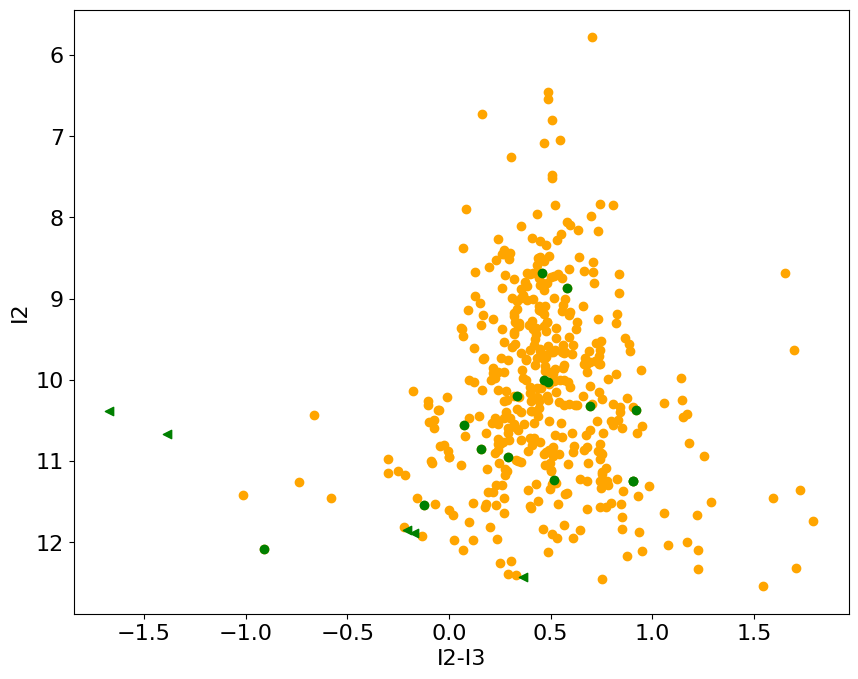

In [101]:
pl.scatter(spitzer['_4.5mag'] - spitzer['_5.8mag'],  spitzer['_4.5mag'], color='orange')
#pl.scatter(spitzer['_4.5mag'][spitzer['_8.0mag'].mask] - i4lim,  spitzer['_4.5mag'][spitzer['_8.0mag'].mask])

magi3mask = spitzer['_5.8mag'].mask
greensrcmask = np.zeros_like(magi3mask, dtype='bool')
greensrcmask[inds_green] = True
pl.scatter(spitzer['_4.5mag'][inds_green] - spitzer['_5.8mag'][inds_green],  spitzer['_4.5mag'][inds_green],
           color='g')
pl.scatter(spitzer['_4.5mag'][greensrcmask & magi3mask] - i3lim,
           spitzer['_4.5mag'][greensrcmask & magi3mask],
           marker='<',
           color='g'
          )
#pl.scatter((spitzer['_4.5mag'] - spitzer['_5.8mag'])[reddish_i1i2_spitzer_and_greeni2i4], 
#           spitzer['_4.5mag'][reddish_i1i2_spitzer_and_greeni2i4],
#          color='r')
#pl.scatter(spitzer['_4.5mag'][reddish_i1i2_spitzer_and_greeni2i4 & mag8mask] - i3lim,
#           spitzer['_4.5mag'][reddish_i1i2_spitzer_and_greeni2i4 & mag8mask],
#           marker='<',
#          )


pl.xlabel("I2-I3")
pl.ylabel("I2")
pl.ylim(pl.ylim()[::-1])

Text(0, 0.5, 'I2-I4')

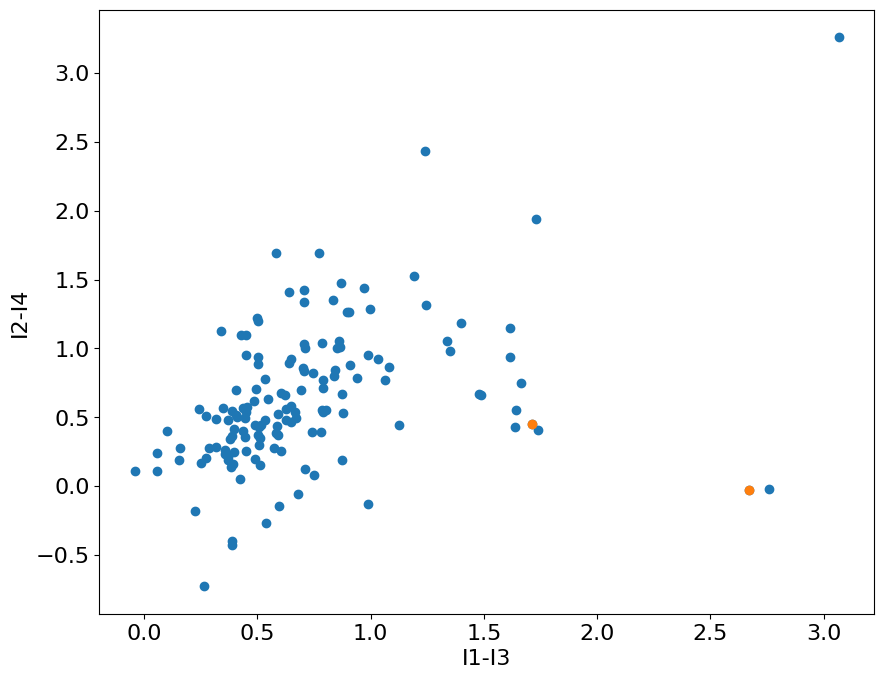

In [102]:
pl.scatter(spitzer['_3.6mag'] - spitzer['_5.8mag'],  spitzer['_4.5mag'] - spitzer['_8.0mag'])
pl.scatter(spitzer['_3.6mag'][inds_green] - spitzer['_5.8mag'][inds_green],  spitzer['_4.5mag'][inds_green] - spitzer['_8.0mag'][inds_green])

pl.xlabel("I1-I3")
pl.ylabel("I2-I4")

### Manual Green Sources from regions

# SEDs again

In [103]:
import sys, imp
sys.path.append(f'{basepath}/analysis/')
import plot_tools
imp.reload(plot_tools)
from plot_tools import starzoom, make_sed

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/quantity.py:550: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(


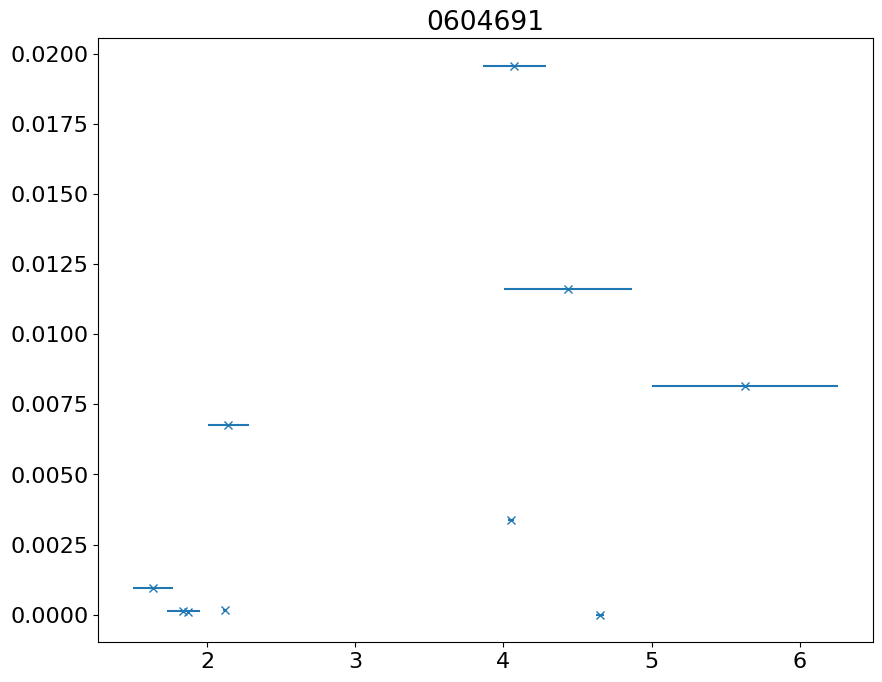

<Figure size 1200x400 with 0 Axes>

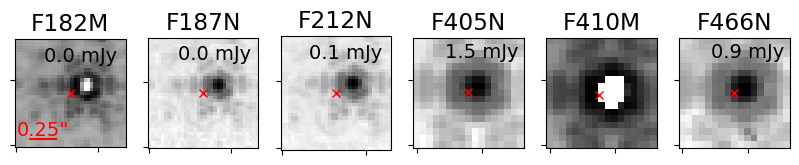

<Figure size 1200x400 with 0 Axes>

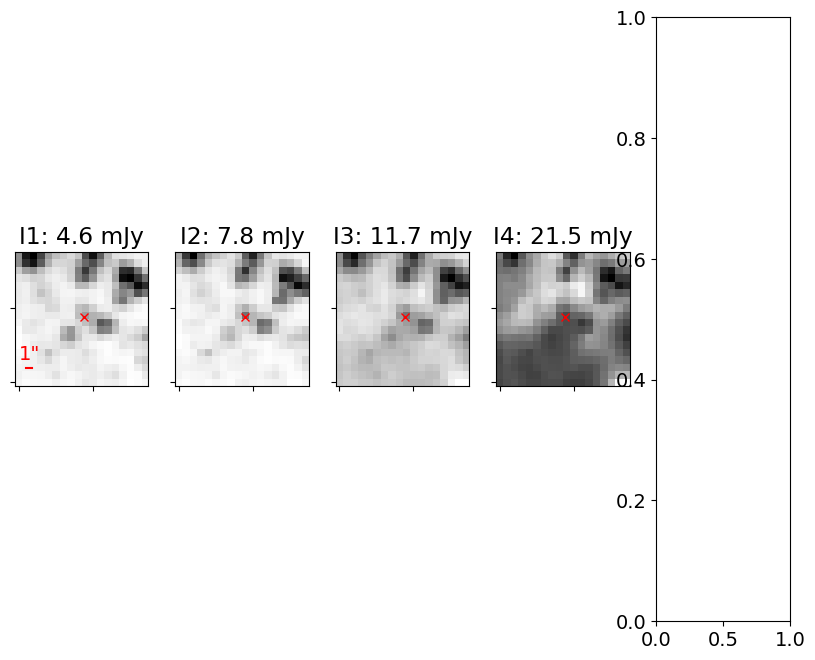

In [104]:
selstar = spitzer[reddish_i1i2_spitzer_and_greeni2i4][0]
coord = SkyCoord(selstar['RAJ2000'], selstar['DEJ2000'], frame='fk5', unit=(u.h, u.deg))
wavelengths, widths, fluxes, lims = make_sed(coord, basetable=basetable, radius=1*u.arcsec)
pl.errorbar(u.Quantity(wavelengths, u.um), u.Quantity([u.Quantity(x, u.Jy) for x in fluxes], u.Jy),
            xerr=[w/2 for w in widths], linestyle='none', marker='x')
pl.title(starid)
starzoom_(coord)

## Exploration of saturated photometry so I can merge it


This is just doodling at the terminal and can be ignored, but I didn't want to delete it...

In [105]:
filtername ='f410m'
satstar_cat_fn = f'{basepath}/{filtername.upper()}/pipeline/jw02221-o001_t001_nircam_clear-{filtername}-merged_i2d_satstar_catalog.fits'
satstar_cat = Table.read(satstar_cat_fn)
satstar_coords = satstar_cat['skycoord_fit']


In [106]:
coord = greenstarregcenters[0]
radius = 0.2*u.arcsec
skycrds_cat = basetable['skycoord_f410m']
idx = coord.separation(skycrds_cat) < radius
print(np.where(idx))
idxsat = coord.separation(satstar_coords) < radius
print(np.where(idxsat), coord.separation(satstar_coords)[idxsat].to(u.arcsec))
basetable[idx]

(array([252744, 252882, 252906, 344419]),)
(array([162]),) [0.00304927arcsec]


<Table length=4>
             skycoord_ref                    sep_f410m        id_f410m            skycoord_f410m                 x_f410m           y_f410m      flux_f410m passno_f410m   dx_f410m  ... flux_jy_410m405 mag_ab_410m405 flux_jy_405m410 mag_ab_405m410 flux_jy_182m187 mag_ab_182m187 flux_jy_187m182 mag_ab_187m182
               deg,deg                          deg                                  deg,deg                                                                                        ...        Jy                             Jy                             Jy                             Jy                     
               SkyCoord                       float64          int64                 SkyCoord                    float64           float64       float32     float64      float32   ...     float32        float32         float32        float32         float32        float32         float32        float32    
-------------------------------------- ---------------------- -------- ------------------------------------ ----------------- ----------------- ---------- ------------ ----------- ... --------------- -------------- --------------- -------------- --------------- -------------- --------------- --------------
266.53710561044187,-28.689561058067603  3.872557727892746e-05   139219 266.5371362125016,-28.68958896878435 4163.047070813245 1263.345298556171   427538.7           -- 0.013711929 ...              --             --              --      11.573935              --      15.837793              --      15.625545
  266.5371605130996,-28.68960755092759 2.8279375767096927e-05   139219 266.5371362125016,-28.68958896878435 4163.047070813245 1263.345298556171   427538.7           -- 0.013711929 ...              --             --              --             --    0.0014538728      15.993685    0.0005868415      16.978699
  266.5371678411927,-28.68954476233498  5.219230622810471e-05   139219 266.5371362125016,-28.68958896878435                --                --         --           --          -- ...              --             --              --      11.573935              --      15.837793              --      15.625545
266.53712880056395,-28.689662178951583  7.349833026488168e-05   139219 266.5371362125016,-28.68958896878435                --                --         --           --          -- ...              --             --              --       16.74596              --      20.109385              --      20.175627

In [107]:
satstar_cat[152]

<Row index=152>
  x_0     y_0         flux_0         id  group_id       x_fit              y_fit            flux_fit                  skycoord_fit                  flux_unc           x_0_unc             y_0_unc      
                                                                                                                        deg,deg                                                                         
float64 float64      float64       int64  int64        float64            float64           float64                     SkyCoord                    float64            float64             float64      
------- ------- ------------------ ----- -------- ------------------ ----------------- ----------------- ------------------------------------- ----------------- ------------------- -------------------
 199.58  863.22 267554.30234180763    75       75 201.05685057023183 863.9025948375161 850937.8807056705 266.5303738953755,-28.759022455908358 6265.107620152947 0.05045251663977841 0.04963824245389914